# NHL Playoff Model - Data Processing Functions

This notebook contains the key data loading and processing functions extracted from the Streamlit app. Use this notebook to test and refine these functions individually.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
import sys

# Install the NHL API package if not already installed
try:
    import nhlpy
    from nhlpy.nhl_client import NHLClient
except ImportError:
    print("Installing NHL API package...")
    !pip install nhl-api-py
    import nhlpy
    from nhlpy.nhl_client import NHLClient

# Initialize NHL client
try:
    client = NHLClient()
    print("NHL client initialized successfully")
except Exception as e:
    print(f"Could not initialize NHL client: {str(e)}")
    client = None

# Constants
current_season = datetime.now().year if datetime.now().month >= 9 else datetime.now().year - 1
season_str = f"{current_season}{current_season+1}"

# Create folders for data storage
data_folder = os.path.join(os.path.dirname(os.path.abspath("__file__")), "data")
model_folder = os.path.join(os.path.dirname(os.path.abspath("__file__")), "models")

# Create folders if they don't exist
os.makedirs(data_folder, exist_ok=True)
os.makedirs(model_folder, exist_ok=True)

print(f"Current season: {season_str}")
print(f"Data folder: {data_folder}")
print(f"Model folder: {model_folder}")

NHL client initialized successfully
Current season: 20242025
Data folder: /workspaces/NHL_playoff_model/data
Model folder: /workspaces/NHL_playoff_model/models


## 1. Get Standings Data

First, let's fetch the current NHL standings data from the API.

In [4]:
def get_standings_data():
    """Get current NHL standings data"""
    try:
        standings_data = client.standings.get_standings()
        return standings_data
    except Exception as e:
        print(f"Error fetching standings data: {str(e)}")
        return None

# Test the function
standings_data = get_standings_data()
print(type(standings_data))
if isinstance(standings_data, dict):
    print(f"Keys in standings_data: {standings_data.keys()}")
    # Show a sample of the data structure
    if "records" in standings_data:
        print(f"Number of divisions: {len(standings_data['records'])}")
        print(f"Sample of the first division: {standings_data['records'][0].keys()}")
    elif "standings" in standings_data:
        print(f"Number of teams: {len(standings_data['standings'])}")
        print(f"Sample of the first team: {standings_data['standings'][0].keys()}")

<class 'dict'>
Keys in standings_data: dict_keys(['wildCardIndicator', 'standingsDateTimeUtc', 'standings'])
Number of teams: 32
Sample of the first team: dict_keys(['clinchIndicator', 'conferenceAbbrev', 'conferenceHomeSequence', 'conferenceL10Sequence', 'conferenceName', 'conferenceRoadSequence', 'conferenceSequence', 'date', 'divisionAbbrev', 'divisionHomeSequence', 'divisionL10Sequence', 'divisionName', 'divisionRoadSequence', 'divisionSequence', 'gameTypeId', 'gamesPlayed', 'goalDifferential', 'goalDifferentialPctg', 'goalAgainst', 'goalFor', 'goalsForPctg', 'homeGamesPlayed', 'homeGoalDifferential', 'homeGoalsAgainst', 'homeGoalsFor', 'homeLosses', 'homeOtLosses', 'homePoints', 'homeRegulationPlusOtWins', 'homeRegulationWins', 'homeTies', 'homeWins', 'l10GamesPlayed', 'l10GoalDifferential', 'l10GoalsAgainst', 'l10GoalsFor', 'l10Losses', 'l10OtLosses', 'l10Points', 'l10RegulationPlusOtWins', 'l10RegulationWins', 'l10Ties', 'l10Wins', 'leagueHomeSequence', 'leagueL10Sequence', 'lea

## 2. Process Standings Data

Next, let's process the raw standings data into a usable DataFrame.

In [5]:
def process_standings_data(standings_data):
    """Process NHL standings data into a DataFrame"""
    all_standings = []
    
    if isinstance(standings_data, dict):
        # Handle format with 'records' key (old format)
        if "records" in standings_data:
            # Loop through each division record
            for division_record in standings_data["records"]:
                division_name = division_record.get("division", {}).get("name", "Unknown")
                conference_name = division_record.get("conference", {}).get("name", "Unknown") if "conference" in division_record else "Unknown"
                
                for team_record in division_record["teamRecords"]:
                    # Start with season and division/conference info
                    team_data = {
                        "season": season_str,
                        "division": division_name,
                        "conference": conference_name
                    }
                    # Process team info
                    team_data["teamId"] = team_record["team"]["id"]
                    team_data["teamName"] = team_record["team"]["name"]
                    team_data["teamAbbrev"] = team_record["team"].get("abbreviation", "")
                    team_data["teamLogo"] = team_record["team"].get("logo", "")
                    
                    # Process all other fields
                    for key, value in team_record.items():
                        if key == "team":  # Already handled above
                            continue
                        
                        if isinstance(value, dict):
                            # Handle nested dictionaries by flattening them
                            for sub_key, sub_value in value.items():
                                team_data[f"{key}_{sub_key}"] = sub_value
                        else:
                            # Regular fields
                            team_data[key] = value
                    
                    all_standings.append(team_data)
        # Handle new format with 'standings' key
        elif "standings" in standings_data:
            for team_record in standings_data["standings"]:
                # Start with season info
                team_data = {
                    "season": season_str
                }
                
                # Extract division and conference info if available
                division_name = team_record.get("divisionName", "Unknown")
                conference_name = team_record.get("conferenceName", "Unknown")
                team_data["division"] = division_name
                team_data["conference"] = conference_name
                
                # Process team info - extract the 'default' value from nested JSON
                team_data["teamId"] = team_record.get("teamId", 0)
                
                if isinstance(team_record.get("teamName"), dict):
                    team_data["teamName"] = team_record["teamName"].get("default", "Unknown")
                else:
                    team_data["teamName"] = team_record.get("teamName", "Unknown")
                    
                if isinstance(team_record.get("teamAbbrev"), dict):
                    team_data["teamAbbrev"] = team_record["teamAbbrev"].get("default", "")
                else:
                    team_data["teamAbbrev"] = team_record.get("teamAbbrev", "")
                    
                team_data["teamLogo"] = team_record.get("teamLogo", "")
                
                # Process all other fields
                for key, value in team_record.items():
                    # Skip already processed keys
                    if key in ["teamId", "teamName", "teamAbbrev", "teamLogo", "divisionName", "conferenceName"]:
                        continue
                    
                    if isinstance(value, dict):
                        # Handle nested dictionaries by flattening them
                        for sub_key, sub_value in value.items():
                            team_data[f"{key}_{sub_key}"] = sub_value
                    else:
                        # Regular fields
                        team_data[key] = value
                
                all_standings.append(team_data)
        else:
            print(f"Unknown standings data format: {list(standings_data.keys())}")
    else:
        print("Non-dictionary standings data response")
    
    # Convert to DataFrame
    if all_standings:
        return pd.DataFrame(all_standings)
    return pd.DataFrame()

# Test the function
if standings_data is not None:
    standings_df = process_standings_data(standings_data)
    print(f"Processed standings data shape: {standings_df.shape}")
    print(f"Columns: {standings_df.columns.tolist()}")
    display(standings_df.head(3))

Processed standings data shape: (32, 85)
Columns: ['season', 'division', 'conference', 'teamId', 'teamName', 'teamAbbrev', 'teamLogo', 'clinchIndicator', 'conferenceAbbrev', 'conferenceHomeSequence', 'conferenceL10Sequence', 'conferenceRoadSequence', 'conferenceSequence', 'date', 'divisionAbbrev', 'divisionHomeSequence', 'divisionL10Sequence', 'divisionRoadSequence', 'divisionSequence', 'gameTypeId', 'gamesPlayed', 'goalDifferential', 'goalDifferentialPctg', 'goalAgainst', 'goalFor', 'goalsForPctg', 'homeGamesPlayed', 'homeGoalDifferential', 'homeGoalsAgainst', 'homeGoalsFor', 'homeLosses', 'homeOtLosses', 'homePoints', 'homeRegulationPlusOtWins', 'homeRegulationWins', 'homeTies', 'homeWins', 'l10GamesPlayed', 'l10GoalDifferential', 'l10GoalsAgainst', 'l10GoalsFor', 'l10Losses', 'l10OtLosses', 'l10Points', 'l10RegulationPlusOtWins', 'l10RegulationWins', 'l10Ties', 'l10Wins', 'leagueHomeSequence', 'leagueL10Sequence', 'leagueRoadSequence', 'leagueSequence', 'losses', 'otLosses', 'placeN

,season,division,conference,teamId,teamName,teamAbbrev,teamLogo,clinchIndicator,conferenceAbbrev,conferenceHomeSequence,...,streakCode,streakCount,teamCommonName_default,ties,waiversSequence,wildcardSequence,winPctg,wins,placeName_fr,teamCommonName_fr
0,20242025,Central,Western,0,Winnipeg Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,p,W,2,...,L,1,Jets,0,32,0,0.679012,55,NaN,NaN
1,20242025,Metropolitan,Eastern,0,Washington Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,z,E,3,...,L,2,Capitals,0,31,0,0.625000,50,NaN,NaN
2,20242025,Pacific,Western,0,Vegas Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,y,W,3,...,W,2,Golden Knights,0,30,0,0.612500,49,NaN,NaN


## 3. Get Team Stats Data

Now let's fetch team stats data from the API.

In [6]:
def get_team_stats_data(start_season=current_season, end_season=current_season):
    """Get team summary stats data directly from NHL API"""
    try:
        # Construct the URL with season parameters
        url = f"https://api.nhle.com/stats/rest/en/team/summary?cayenneExp=seasonId>={start_season}{start_season+1} and seasonId<={end_season}{end_season+1}"
        
        # Make direct API request
        print(f"Fetching team stats data from: {url}")
        response = requests.get(url)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        stats_data = response.json().get('data', [])
        print(f"Successfully retrieved stats data for {len(stats_data)} teams")
        return stats_data
    except Exception as e:
        print(f"Error fetching team stats data: {str(e)}")
        return None

# Test the function
print("Testing get_team_stats_data function...")
stats_data = get_team_stats_data()

# Preview the results
if stats_data:
    print(f"Number of teams: {len(stats_data)}")
    print("\nSample of first team data:")
    for key, value in list(stats_data[0].items())[:10]:  # First 10 items of first team
        print(f"{key}: {value}")
    
    # Show a few more useful stats columns if they exist in the response
    print("\nKey stats columns (if available):")
    key_stats = ['teamName', 'gamesPlayed', 'wins', 'losses', 'otLosses', 
                'goalsFor', 'goalsAgainst', 'pointPctg', 'ppPctg', 'pkPctg']
    
    if len(stats_data) > 0:
        sample_team = stats_data[0]
        for stat in key_stats:
            if stat in sample_team:
                print(f"{stat}: {sample_team[stat]}")
else:
    print("No stats data retrieved, check API endpoint or connection")

Testing get_team_stats_data function...
Fetching team stats data from: https://api.nhle.com/stats/rest/en/team/summary?cayenneExp=seasonId>=20242025 and seasonId<=20242025
Successfully retrieved stats data for 32 teams
Number of teams: 32

Sample of first team data:
faceoffWinPct: 0.477751
gamesPlayed: 80
goalsAgainst: 279
goalsAgainstPerGame: 3.4875
goalsFor: 260
goalsForPerGame: 3.25
losses: 38
otLosses: 7
penaltyKillNetPct: 0.801687
penaltyKillPct: 0.763714

Key stats columns (if available):
gamesPlayed: 80
wins: 35
losses: 38
otLosses: 7
goalsFor: 260
goalsAgainst: 279
Successfully retrieved stats data for 32 teams
Number of teams: 32

Sample of first team data:
faceoffWinPct: 0.477751
gamesPlayed: 80
goalsAgainst: 279
goalsAgainstPerGame: 3.4875
goalsFor: 260
goalsForPerGame: 3.25
losses: 38
otLosses: 7
penaltyKillNetPct: 0.801687
penaltyKillPct: 0.763714

Key stats columns (if available):
gamesPlayed: 80
wins: 35
losses: 38
otLosses: 7
goalsFor: 260
goalsAgainst: 279


## 4. Process Team Stats Data

Process the raw team stats data into a usable DataFrame.

In [7]:
def process_team_stats_data(stats_data, standings_df=None):
    """Process team stats data into a DataFrame with team names standardized."""
    all_stats_data = []
    
    # Process stats data
    if isinstance(stats_data, list):
        for team_stats in stats_data:
            team_data = {}
            for key, value in team_stats.items():
                if isinstance(value, dict):
                    for sub_key, sub_value in value.items():
                        team_data[f"{key}_{sub_key}"] = sub_value
                else:
                    team_data[key] = value
            all_stats_data.append(team_data)
    
    # Convert to DataFrame
    if all_stats_data:
        stats_df = pd.DataFrame(all_stats_data)
        
        # Format percentages
        pct_cols = [col for col in stats_df.columns if 'Pct' in col]
        for col in pct_cols:
            if col in stats_df.columns and pd.api.types.is_numeric_dtype(stats_df[col]):
                stats_df[col] = (stats_df[col] * 100).round(1).astype(str) + '%'
        
        # Basic column renaming - change teamFullName to teamName instead of team_name
        rename_dict = {
            'seasonId': 'season',
            'teamName': 'teamName',  # Keep teamName as is
            'teamFullName': 'teamName',  # Rename teamFullName to teamName
            'gamesPlayed': 'GP',
            'wins': 'W',
            'losses': 'L',
            'otLosses': 'OTL',
            'points': 'PTS',
            'pointPct': 'PTS%',
            'goalsFor': 'GF',
            'goalsAgainst': 'GA',
            'powerPlayPct': 'PP%',
            'penaltyKillPct': 'PK%',
            'faceoffWinPct': 'FO%'
        }
        rename_dict = {k: v for k, v in rename_dict.items() if k in stats_df.columns}
        stats_df = stats_df.rename(columns=rename_dict)
        
        # Rename team_name to teamName if it exists (from previous processing)
        if 'team_name' in stats_df.columns:
            stats_df = stats_df.rename(columns={'team_name': 'teamName'})
        
        # Ensure we have a teamName column for merging later
        if 'teamName' not in stats_df.columns:
            print("WARNING: No teamName column available for team name merging")
        else:
            print(f"Successfully processed {len(stats_df)} teams with standardized team names")
        
        return stats_df
    return pd.DataFrame()

# Test the function with standings data
if stats_data is not None:
    # Check if standings_df exists and pass it to the function
    if 'standings_df' in locals() and not standings_df.empty:
        stats_df = process_team_stats_data(stats_data, standings_df)
    else:
        stats_df = process_team_stats_data(stats_data)
    
    print(f"Processed team stats data shape: {stats_df.shape}")
    print(f"Columns: {stats_df.columns.tolist()}")
    display(stats_df.head(3))

Successfully processed 32 teams with standardized team names
Processed team stats data shape: (32, 24)
Columns: ['FO%', 'GP', 'GA', 'goalsAgainstPerGame', 'GF', 'goalsForPerGame', 'L', 'OTL', 'penaltyKillNetPct', 'PK%', 'PTS%', 'PTS', 'powerPlayNetPct', 'PP%', 'regulationAndOtWins', 'season', 'shotsAgainstPerGame', 'shotsForPerGame', 'teamName', 'teamId', 'ties', 'W', 'winsInRegulation', 'winsInShootout']


,FO%,GP,GA,goalsAgainstPerGame,GF,goalsForPerGame,L,OTL,penaltyKillNetPct,PK%,...,regulationAndOtWins,season,shotsAgainstPerGame,shotsForPerGame,teamName,teamId,ties,W,winsInRegulation,winsInShootout
0,47.8%,80,279,3.4875,260,3.2500,38,7,80.2%,76.4%,...,31,20242025,28.90,27.6500,Buffalo Sabres,7,None,35,28,4
1,53.7%,80,226,2.8250,259,3.2375,26,4,80.5%,77.9%,...,49,20242025,29.20,28.0625,Toronto Maple Leafs,10,None,50,39,1
2,44.5%,80,256,3.2000,214,2.6750,37,8,74.8%,73.6%,...,31,20242025,32.05,27.6250,Anaheim Ducks,24,None,35,24,4


## 5. Get Advanced Stats Data

Fetch advanced stats data from MoneyPuck for the current season.

In [8]:
def process_advanced_stats(df, season_str, situation):
    """Process the advanced stats dataframe while preserving all required columns."""
    # Check if we have data
    if df.empty:
        print("Loaded DataFrame is empty")
        return df
    
    # Show a preview of the data structure
    print("\nData columns:")
    print(df.columns.tolist())
    
    print("\nSample of teams:")
    if 'team' in df.columns:
        print(df['team'].unique())
    
    print("\nAvailable situations:")
    if 'situation' in df.columns:
        print(df['situation'].unique())
        
        # Filter by situation if available
        situation_values = df['situation'].unique()
        matching_situations = [s for s in situation_values if situation.lower() in s.lower()]
        
        if matching_situations:
            situation_filter = matching_situations[0]
            df = df[df['situation'] == situation_filter].copy()
            print(f"\nFiltered to {situation_filter} data: {len(df)} rows")
        else:
            print(f"\nWarning: Requested situation '{situation}' not found in data")
            # Just use the first situation in this case
            if len(situation_values) > 0:
                df = df[df['situation'] == situation_values[0]].copy()
                print(f"Using '{situation_values[0]}' instead: {len(df)} rows")
    
    # Add season information if not present
    if 'season' not in df.columns:
        df['season'] = season_str

    # Clean up unnecessary columns
    columns_to_drop = ['name', 'team.1', 'position']
    for col in columns_to_drop:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
        
    # Rename columns to remove spaces and special characters
    df.columns = df.columns.str.replace(' ', '_').str.replace('.', '_').str.replace('-', '_')
    # Remove any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Convert columns to numeric where possible
    for col in df.columns:
        if col not in ['team', 'situation', 'season']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    print(f"\nReturning advanced stats DataFrame with {len(df)} rows and {len(df.columns)} columns")
    return df


def create_empty_advanced_stats_df():
    """Create an empty DataFrame with all required advanced stats columns."""
    print("Creating empty DataFrame with all required columns...")
    columns = [
        'team', 'season', 'situation', 'games_played',
        'xGoalsPercentage', 'corsiPercentage', 'fenwickPercentage', 'iceTime',
        'xOnGoalFor', 'xGoalsFor', 'xReboundsFor', 'xFreezeFor', 'xPlayStoppedFor',
        'xPlayContinuedInZoneFor', 'xPlayContinuedOutsideZoneFor', 'flurryAdjustedxGoalsFor',
        'scoreVenueAdjustedxGoalsFor', 'flurryScoreVenueAdjustedxGoalsFor', 'shotsOnGoalFor',
        'missedShotsFor', 'blockedShotAttemptsFor', 'shotAttemptsFor', 'goalsFor',
        'reboundsFor', 'reboundGoalsFor', 'freezeFor', 'playStoppedFor',
        'playContinuedInZoneFor', 'playContinuedOutsideZoneFor', 'savedShotsOnGoalFor',
        'savedUnblockedShotAttemptsFor', 'penaltiesFor', 'penalityMinutesFor',
        'faceOffsWonFor', 'hitsFor', 'takeawaysFor', 'giveawaysFor',
        'lowDangerShotsFor', 'mediumDangerShotsFor', 'highDangerShotsFor',
        'lowDangerxGoalsFor', 'mediumDangerxGoalsFor', 'highDangerxGoalsFor',
        'lowDangerGoalsFor', 'mediumDangerGoalsFor', 'highDangerGoalsFor',
        'scoreAdjustedShotsAttemptsFor', 'unblockedShotAttemptsFor',
        'scoreAdjustedUnblockedShotAttemptsFor', 'dZoneGiveawaysFor',
        'xGoalsFromxReboundsOfShotsFor', 'xGoalsFromActualReboundsOfShotsFor',
        'reboundxGoalsFor', 'totalShotCreditFor', 'scoreAdjustedTotalShotCreditFor',
        'scoreFlurryAdjustedTotalShotCreditFor', 'xOnGoalAgainst', 'xGoalsAgainst',
        'xReboundsAgainst', 'xFreezeAgainst', 'xPlayStoppedAgainst',
        'xPlayContinuedInZoneAgainst', 'xPlayContinuedOutsideZoneAgainst',
        'flurryAdjustedxGoalsAgainst', 'scoreVenueAdjustedxGoalsAgainst',
        'flurryScoreVenueAdjustedxGoalsAgainst', 'shotsOnGoalAgainst',
        'missedShotsAgainst', 'blockedShotAttemptsAgainst', 'shotAttemptsAgainst',
        'goalsAgainst', 'reboundsAgainst', 'reboundGoalsAgainst', 'freezeAgainst',
        'playStoppedAgainst', 'playContinuedInZoneAgainst', 'playContinuedOutsideZoneAgainst',
        'savedShotsOnGoalAgainst', 'savedUnblockedShotAttemptsAgainst',
        'penaltiesAgainst', 'penalityMinutesAgainst', 'faceOffsWonAgainst',
        'hitsAgainst', 'takeawaysAgainst', 'giveawaysAgainst', 'lowDangerShotsAgainst',
        'mediumDangerShotsAgainst', 'highDangerShotsAgainst', 'lowDangerxGoalsAgainst',
        'mediumDangerxGoalsAgainst', 'highDangerxGoalsAgainst', 'lowDangerGoalsAgainst',
        'mediumDangerGoalsAgainst', 'highDangerGoalsAgainst',
        'scoreAdjustedShotsAttemptsAgainst', 'unblockedShotAttemptsAgainst',
        'scoreAdjustedUnblockedShotAttemptsAgainst', 'dZoneGiveawaysAgainst',
        'xGoalsFromxReboundsOfShotsAgainst', 'xGoalsFromActualReboundsOfShotsAgainst',
        'reboundxGoalsAgainst', 'totalShotCreditAgainst',
        'scoreAdjustedTotalShotCreditAgainst', 'scoreFlurryAdjustedTotalShotCreditAgainst'
    ]
    return pd.DataFrame(columns=columns)


def get_advanced_stats_data(season=current_season, situation='5on5'):
    """Get advanced stats from MoneyPuck.
    
    Args:
        season (int): NHL season starting year (e.g., 2023 for 2023-2024 season)
        situation (str): Game situation to filter (default: '5on5')
        
    Returns:
        DataFrame: Advanced stats data for the specified season and situation
    """
    # Construct the MoneyPuck URL for the current season
    url = f"https://moneypuck.com/moneypuck/playerData/seasonSummary/{season}/regular/teams.csv"
    csv_path = os.path.join(data_folder, f"moneypuck_regular_{season}.csv")
    
    print(f"Fetching advanced stats from: {url}")
    
    try:
        # First try to load from local cache if it exists
        if os.path.exists(csv_path):
            print(f"Found local cache: {csv_path}")
            try:
                df = pd.read_csv(csv_path)
                print(f"Successfully loaded {len(df)} rows from local cache")
                if not df.empty:
                    return process_advanced_stats(df, season_str, situation)
            except Exception as cache_error:
                print(f"Error loading from cache: {str(cache_error)}")
        
        # If no cache or cache failed, try downloading with proper headers
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
            'Cache-Control': 'max-age=0'
        }
        
        print("Requesting data with browser headers...")
        response = requests.get(url, headers=headers, timeout=10)
        
        # Check if successful
        if response.status_code == 200:
            # Save the raw content to a temporary file and read it with pandas
            with open("temp_data.csv", "wb") as f:
                f.write(response.content)
            
            df = pd.read_csv("temp_data.csv")
            print(f"Successfully loaded data with {len(df)} rows")
            
            # Save a local copy for future use
            df.to_csv(csv_path, index=False)
            print(f"Saved local copy to {csv_path}")
            
            return process_advanced_stats(df, season_str, situation)
        else:
            print(f"Request failed with status code: {response.status_code}")
            return create_empty_advanced_stats_df()
                
    except Exception as e:
        print(f"Error in get_advanced_stats_data: {str(e)}")
        return create_empty_advanced_stats_df()


# Example usage to test the function
if __name__ == "__main__":
    # Call the function to get the data
    advanced_stats_df = get_advanced_stats_data(current_season, '5on5')
    
    # Show a preview of the results
    if not advanced_stats_df.empty:
        print("\nAdvanced stats preview:")
        # Show key advanced metrics - expanded list
        key_advanced_metrics = [
            'team', 'games_played', 'xGoalsPercentage', 'corsiPercentage', 
            'fenwickPercentage', 'goalsFor', 'goalsAgainst', 'shotsOnGoalFor',
            'shotsOnGoalAgainst', 'iceTime', 'hitsFor', 'hitsAgainst',
            'takeawaysFor', 'takeawaysAgainst', 'dZoneGiveawaysFor'
        ]
        
        # Display only columns that exist in the DataFrame
        display_cols = [col for col in key_advanced_metrics if col in advanced_stats_df.columns]
        if display_cols:
            print(advanced_stats_df[display_cols].head())  # Using print instead of display for notebook-agnostic code
        else:
            print("No matching columns found for display")
    else:
        print("\nNo advanced stats data available")

Fetching advanced stats from: https://moneypuck.com/moneypuck/playerData/seasonSummary/2024/regular/teams.csv
Found local cache: /workspaces/NHL_playoff_model/data/moneypuck_regular_2024.csv
Successfully loaded 160 rows from local cache

Data columns:
['team', 'season', 'name', 'team.1', 'position', 'situation', 'games_played', 'xGoalsPercentage', 'corsiPercentage', 'fenwickPercentage', 'iceTime', 'xOnGoalFor', 'xGoalsFor', 'xReboundsFor', 'xFreezeFor', 'xPlayStoppedFor', 'xPlayContinuedInZoneFor', 'xPlayContinuedOutsideZoneFor', 'flurryAdjustedxGoalsFor', 'scoreVenueAdjustedxGoalsFor', 'flurryScoreVenueAdjustedxGoalsFor', 'shotsOnGoalFor', 'missedShotsFor', 'blockedShotAttemptsFor', 'shotAttemptsFor', 'goalsFor', 'reboundsFor', 'reboundGoalsFor', 'freezeFor', 'playStoppedFor', 'playContinuedInZoneFor', 'playContinuedOutsideZoneFor', 'savedShotsOnGoalFor', 'savedUnblockedShotAttemptsFor', 'penaltiesFor', 'penalityMinutesFor', 'faceOffsWonFor', 'hitsFor', 'takeawaysFor', 'giveawaysFor',

## 6. Merge Data and Engineer Features

Now let's combine all the data sources and engineer features for the prediction model.

In [9]:
def engineer_features(combined_data):
    """Engineer features for the prediction model"""
    # Create a copy of the data to avoid modifying original
    df = combined_data.copy()
    
    # Convert percentage strings to floats where needed
    for col in df.columns:
        if df[col].dtype == object and df[col].str.contains('%').any():
            df[col] = df[col].str.rstrip('%').astype(float) / 100
    
    # Calculate additional metrics from the data
    if all(col in df.columns for col in ['goalDifferential', 'gamesPlayed']):
        df['goalDiff/G'] = df['goalDifferential'] / df['gamesPlayed']
    
    if all(col in df.columns for col in ['homeRegulationWins', 'gamesPlayed']):
        df['homeRegulationWin%'] = df['homeRegulationWins'] / df['gamesPlayed']
    
    if all(col in df.columns for col in ['roadRegulationWins', 'gamesPlayed']):
        df['roadRegulationWin%'] = df['roadRegulationWins'] / df['gamesPlayed']
    
    # Advanced metrics - add checks to ensure columns exist before calculating
    if all(col in df.columns for col in ['flurryScoreVenueAdjustedxGoalsAgainst', 'goalsAgainst', 'iceTime']):
        df['adjGoalsSavedAboveX/60'] = (df['flurryScoreVenueAdjustedxGoalsAgainst'] - df['goalsAgainst']) / df['iceTime'] * 60
    
    if all(col in df.columns for col in ['goalsFor', 'flurryScoreVenueAdjustedxGoalsFor', 'iceTime']):
        df['adjGoalsScoredAboveX/60'] = (df['goalsFor'] - df['flurryScoreVenueAdjustedxGoalsFor']) / df['iceTime'] * 60
    
    # Calculate possession-normalized metrics if columns exist
    cols_for_hits = ['hitsFor', 'hitsAgainst']
    if all(col in df.columns for col in cols_for_hits):
        df['hitsPctg'] = df['hitsFor'] / (df['hitsAgainst'] + df['hitsFor'])
    
    cols_for_takeaways = ['takeawaysFor', 'takeawaysAgainst']
    if all(col in df.columns for col in cols_for_takeaways):
        df['takeawaysPctg'] = df['takeawaysFor'] / (df['takeawaysAgainst'] + df['takeawaysFor'])
    
    cols_for_giveaways = ['giveawaysFor', 'giveawaysAgainst']
    if all(col in df.columns for col in cols_for_giveaways):
        df['giveawaysPctg'] = df['giveawaysFor'] / (df['giveawaysAgainst'] + df['giveawaysFor'])
    
    cols_for_dzone = ['dZoneGiveawaysFor', 'dZoneGiveawaysAgainst']
    if all(col in df.columns for col in cols_for_dzone):
        df['dZoneGiveawaysPctg'] = df['dZoneGiveawaysFor'] / (df['dZoneGiveawaysAgainst'] + df['dZoneGiveawaysFor'])
    
    # Apply possession adjustment if corsiPercentage exists
    if 'corsiPercentage' in df.columns and 'hitsPctg' in df.columns:
        df['possAdjHitsPctg'] = df['hitsPctg'] * (0.5 / (1 - df['corsiPercentage'].clip(0.01, 0.99)))
    
    if 'corsiPercentage' in df.columns and 'takeawaysPctg' in df.columns:
        df['possAdjTakeawaysPctg'] = df['takeawaysPctg'] * (0.5 / (1 - df['corsiPercentage'].clip(0.01, 0.99)))
    
    if 'corsiPercentage' in df.columns and 'giveawaysPctg' in df.columns:
        df['possAdjGiveawaysPctg'] = df['giveawaysPctg'] * (0.5 / df['corsiPercentage'].clip(0.01, 0.99))
    
    if 'corsiPercentage' in df.columns and 'dZoneGiveawaysPctg' in df.columns:
        df['possAdjdZoneGiveawaysPctg'] = df['dZoneGiveawaysPctg'] * (0.5 / df['corsiPercentage'].clip(0.01, 0.99))
    
    if all(col in df.columns for col in ['possAdjGiveawaysPctg', 'possAdjdZoneGiveawaysPctg']):
        df['possTypeAdjGiveawaysPctg'] = df['possAdjGiveawaysPctg'] * 1/3 + df['possAdjdZoneGiveawaysPctg'] * 2/3
    
    if all(col in df.columns for col in ['reboundxGoalsFor', 'reboundxGoalsAgainst']):
        df['reboundxGoalsPctg'] = df['reboundxGoalsFor'] / (df['reboundxGoalsFor'] + df['reboundxGoalsAgainst'])
    
    # Calculate special teams metrics if they exist
    if all(col in df.columns for col in ['PP%', 'PK%']):
        # Convert percentage strings to floats if needed
        for col in ['PP%', 'PK%']:
            if df[col].dtype == object and df[col].str.contains('%').any():
                df[col] = df[col].str.rstrip('%').astype(float) / 100
        
        # Calculate league averages
        league_avg_pp = df['PP%'].mean()
        league_avg_pk = df['PK%'].mean()
        
        # Calculate relative metrics
        df['PP%_rel'] = df['PP%'] - league_avg_pp
        df['PK%_rel'] = df['PK%'] - league_avg_pk
        
        # Create composite special teams metric
        df['special_teams_composite'] = df['PP%_rel'] + df['PK%_rel']
    
    # Return the dataframe with engineered features
    return df

# Combine and process all data
print("Combining and processing data...")
if 'standings_df' in locals() and 'stats_df' in locals() and not standings_df.empty and not stats_df.empty:
    # First, check the key columns for merging
    print(f"\nStandings DataFrame season column: {standings_df['season'].iloc[0] if 'season' in standings_df.columns else 'Not found'}")
    print(f"Stats DataFrame season column: {stats_df['season'].iloc[0] if 'season' in stats_df.columns else 'Not found'}")
    
    print(f"\nStandings DataFrame team column values (first 3): {standings_df['teamName'].iloc[:3].tolist() if 'teamName' in standings_df.columns else 'Not found'}")
    print(f"Stats DataFrame team column values (first 3): {stats_df['teamName'].iloc[:3].tolist() if 'teamName' in stats_df.columns else 'Not found'}")
    
    try:
        # Merge the dataframes
        # Convert season columns to the same type before merging
        standings_df['season'] = standings_df['season'].astype(str)
        stats_df['season'] = stats_df['season'].astype(str)
        
        # Create consistent team column names for merging
        if 'team' in standings_df.columns:
            standings_df['teamName'] = standings_df['teamName'].str.strip()
        if 'team' in stats_df.columns:
            stats_df['teamName'] = stats_df['teamName'].str.strip()
        
        # Perform the merge
        team_data = pd.merge(standings_df, stats_df, on=['season', 'teamName'], how='inner')
        print(f"\nMerged data shape: {team_data.shape}")
        print(f"Successfully merged {len(team_data)} teams")
        
        # Add this code to the section where you prepare advanced_stats_df for merging
        if 'advanced_stats_df' in locals() and not advanced_stats_df.empty and 'team' in advanced_stats_df.columns:
            # Make sure season columns have the same type and format
            if 'season' in advanced_stats_df.columns:
                # Convert season from "2024" to "20242025" format
                advanced_stats_df['season'] = advanced_stats_df['season'].astype(str).apply(
                    lambda x: f"{x}{int(x)+1}" if len(x) == 4 and x.isdigit() else x
                )
                advanced_stats_df['season'] = advanced_stats_df['season'].astype(str)
                print(f"Reformatted advanced stats season column to match required format: {advanced_stats_df['season'].iloc[0]}")

            # Normalize team names if needed
            if 'team' in advanced_stats_df.columns:
                advanced_stats_df['team'] = advanced_stats_df['team'].str.strip()

            # Perform the merge with the correct columns
            team_data = pd.merge(team_data, advanced_stats_df, 
                     left_on=['season', 'teamAbbrev'],
                     right_on=['season', 'team'],
                     how='left')
            print(f"Merged data with advanced stats shape: {team_data.shape}")
        
        # Engineer features
        team_data = engineer_features(team_data)
        print(f"Final data shape after feature engineering: {team_data.shape}")
        print(f"Final columns: {team_data.columns.tolist()[:10]} ... (and {len(team_data.columns)-10} more)")
        
        # Display a few rows of the final data
        try:
            from IPython.display import display
            display(team_data.iloc[:3, :10])  # Show first 3 rows and 10 columns
        except ImportError:
            print(team_data.iloc[:3, :10])  # Fallback if not in a notebook environment
            
    except Exception as e:
        print(f"Error merging data: {str(e)}")
else:
    print("No data available to merge")

Combining and processing data...

Standings DataFrame season column: 20242025
Stats DataFrame season column: 20242025

Standings DataFrame team column values (first 3): ['Winnipeg Jets', 'Washington Capitals', 'Vegas Golden Knights']
Stats DataFrame team column values (first 3): ['Buffalo Sabres', 'Toronto Maple Leafs', 'Anaheim Ducks']

Merged data shape: (32, 107)
Successfully merged 32 teams
Reformatted advanced stats season column to match required format: 20242025
Merged data with advanced stats shape: (32, 210)
Final data shape after feature engineering: (32, 228)
Final columns: ['season', 'division', 'conference', 'teamId_x', 'teamName', 'teamAbbrev', 'teamLogo', 'clinchIndicator', 'conferenceAbbrev', 'conferenceHomeSequence'] ... (and 218 more)


,season,division,conference,teamId_x,teamName,teamAbbrev,teamLogo,clinchIndicator,conferenceAbbrev,conferenceHomeSequence
0,20242025,Central,Western,0,Winnipeg Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,p,W,2
1,20242025,Metropolitan,Eastern,0,Washington Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,z,E,3
2,20242025,Pacific,Western,0,Vegas Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,y,W,3


In [10]:
# Add playoff history metrics after all data sources are merged
def add_playoff_history_metrics(team_data):
    """Add playoff history metrics to the combined team data."""
    try:
        # Load the playoff history data with proper path handling
        playoff_history_path = os.path.join(data_folder, "nhl_playoff_wins_2005_present.csv")
        playoff_history = pd.read_csv(playoff_history_path)
        
        print(f"Loaded playoff history data: {playoff_history.shape}")
        
        # Add rounds_won if it doesn't exist already
        if 'rounds_won' not in playoff_history.columns:
            playoff_history['rounds_won'] = ((playoff_history['wins'] - (playoff_history['wins'] % 4)) / 4).astype(int)
            print("Added rounds_won column to playoff history data")
        
        # Calculate playoff history metrics
        seasons = team_data['season'].unique()
        history_data = calculate_playoff_history(playoff_history, seasons, team_data)
        
        print(f"Generated playoff history metrics for {len(history_data)} team-seasons")
        
        # Merge playoff history metrics with team data
        team_data_with_history = pd.merge(
            team_data,
            history_data,
            on=['teamAbbrev', 'season'],
            how='left'
        )
        
        # Fill NaN values for teams with no playoff history
        for col in ['weighted_playoff_wins', 'weighted_playoff_rounds', 'playoff_performance_score']:
            if col in team_data_with_history.columns:
                team_data_with_history[col] = team_data_with_history[col].fillna(0)
        
        print(f"Successfully merged playoff history metrics")
        return team_data_with_history
        
    except FileNotFoundError:
        print(f"Warning: Playoff history data file not found at {playoff_history_path}")
        return team_data
    except Exception as e:
        print(f"Error adding playoff history: {str(e)}")
        return team_data

def calculate_playoff_history(playoff_df, seasons, team_data, num_seasons=2):
    """
    Calculate playoff history metrics for all teams across multiple seasons
    
    Parameters:
    -----------
    playoff_df: DataFrame with playoff history data
    seasons: List of unique seasons to process
    team_data: DataFrame with team data including teamAbbrev and season
    num_seasons: Number of prior seasons to consider
    
    Returns:
    --------
    DataFrame with weighted playoff metrics for each team-season
    """
    weights = [0.6, 0.4]  # Weights for previous seasons
    history_data = []
    
    # Create a mapping between team and teamAbbrev from team_data
    team_abbrev_map = {}
    if 'teamAbbrev' in team_data.columns:
        # Get unique team-abbrev pairs
        team_abbrev_pairs = team_data[['teamName', 'teamAbbrev']].drop_duplicates()
        team_abbrev_map = dict(zip(team_abbrev_pairs['teamName'], team_abbrev_pairs['teamAbbrev']))
    
    for season in seasons:
        # Get current year from season
        current_year = int(str(season)[:4]) if len(str(season)) >= 4 else int(season)
        
        # Get all teams for this season from the team_data
        current_teams_df = team_data[team_data['season'] == season]
        
        if 'teamAbbrev' not in current_teams_df.columns:
            print(f"Warning: teamAbbrev column missing for season {season}")
            continue
            
        # Process each team
        for _, team_row in current_teams_df.iterrows():
            team_abbrev = team_row['teamAbbrev']
            team_name = team_row['teamName']
            
            weighted_wins = 0
            weighted_rounds = 0
            
            # Look at prior seasons
            for i in range(1, num_seasons + 1):
                if i <= len(weights):  # Make sure we have a weight for this season
                    prev_year = current_year - i
                    prev_season = int(f"{prev_year}{prev_year+1}")
                    
                    # Try to find a match by team name first
                    prev_record = playoff_df[(playoff_df['team'] == team_name) & 
                                           (playoff_df['season'] == prev_season)]
                    
                    # If no match, try abbreviation
                    if prev_record.empty and team_abbrev:
                        prev_record = playoff_df[(playoff_df['team'] == team_abbrev) & 
                                               (playoff_df['season'] == prev_season)]
                    
                    if not prev_record.empty:
                        # Get playoff wins and rounds won
                        wins = prev_record['wins'].values[0]
                        rounds = prev_record['rounds_won'].values[0]
                        
                        # Apply weights
                        weighted_wins += wins * weights[i-1]
                        weighted_rounds += rounds * weights[i-1]
            
            # Store results
            history_data.append({
                'teamAbbrev': team_abbrev,
                'season': season,
                'weighted_playoff_wins': weighted_wins,
                'weighted_playoff_rounds': weighted_rounds,
                'playoff_performance_score': weighted_wins/4*.75 + weighted_rounds*1.25
            })
    
    return pd.DataFrame(history_data)

# Add this code to the section after data merging in the engineer_features function
if 'team_data' in locals() and not team_data.empty:
    print("\nAdding playoff history metrics...")
    team_data = add_playoff_history_metrics(team_data)
    print(f"Final team data shape with playoff history: {team_data.shape}")
    
    # Display sample of the playoff history metrics
    playoff_cols = ['teamName', 'season', 'weighted_playoff_wins', 'weighted_playoff_rounds', 'playoff_performance_score']
    available_cols = [col for col in playoff_cols if col in team_data.columns]
    
    if available_cols:
        print("\nSample of playoff history metrics:")
        sample_df = team_data[available_cols].sort_values('playoff_performance_score', ascending=False).head(5)
        display(sample_df)


Adding playoff history metrics...
Loaded playoff history data: (332, 4)
Added rounds_won column to playoff history data
Generated playoff history metrics for 32 team-seasons
Successfully merged playoff history metrics
Final team data shape with playoff history: (32, 231)

Sample of playoff history metrics:


,teamName,season,weighted_playoff_wins,weighted_playoff_rounds,playoff_performance_score
10,Florida Panthers,20242025,14.8,3.6,7.2750
9,Edmonton Oilers,20242025,11.4,2.2,4.8875
3,Dallas Stars,20242025,10.0,2.0,4.3750
2,Vegas Golden Knights,20242025,8.2,1.6,3.5375
8,Carolina Hurricanes,20242025,6.8,1.4,3.0250


## 7. Determine Playoff Teams and Create Matchups

This function determines which teams make the playoffs and creates the matchups.

In [11]:
def determine_playoff_teams(standings_df):
    """Determine which teams make the playoffs based on NHL rules."""
    # Ensure standings DataFrame is sorted properly
    if standings_df.empty:
        print("No standings data available")
        return {}
    
    # Make sure we have the required columns
    required_cols = ['conference', 'division', 'teamName', 'teamAbbrev', 'points', 'teamLogo']
    if not all(col in standings_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in standings_df.columns]
        print(f"Missing required columns in standings data: {missing}")
        return {}
    
    # Group by conference
    conferences = standings_df['conference'].unique()
    playoff_matchups = {}
    
    for conference in conferences:
        conf_teams = standings_df[standings_df['conference'] == conference].copy()
        divisions = conf_teams['division'].unique()
        
        division_qualifiers = []
        wildcard_candidates = []
        
        # Get top 3 from each division
        for division in divisions:
            div_teams = conf_teams[conf_teams['division'] == division].copy()
            
            # Determine available tiebreaker columns
            sort_columns = ['points']
            tiebreakers = ['regulationWins', 'regulationAndOtWins', 'winsInRegulation', 'wins', 'goalDifferential', 'goalsForPerGame']
            
            for tiebreaker in tiebreakers:
                if tiebreaker in div_teams.columns:
                    sort_columns.append(tiebreaker)
                    
            # Sort using available columns
            div_teams = div_teams.sort_values(by=sort_columns, ascending=False)
            
            # Top 3 teams in division qualify automatically
            division_top3 = div_teams.head(3).copy()
            division_top3['seed_type'] = 'division'
            division_top3['division_rank'] = range(1, 4)
            
            division_qualifiers.append(division_top3)
            
            # Remaining teams are wildcard candidates
            wildcard_candidates.append(div_teams.iloc[3:].copy())
        
        # Combine division qualifiers
        division_qualifiers_df = pd.concat(division_qualifiers) if division_qualifiers else pd.DataFrame()
        
        # Combine and rank wildcard candidates
        wildcard_df = pd.DataFrame()
        if wildcard_candidates:
            wildcard_df = pd.concat(wildcard_candidates)
            
            # Use the same tiebreaker logic for wildcards
            sort_columns = ['points']
            tiebreakers = ['regulationWins', 'regulationAndOtWins', 'winsInRegulation', 'wins', 'goalDifferential', 'goalsForPerGame']
            
            for tiebreaker in tiebreakers:
                if tiebreaker in wildcard_df.columns:
                    sort_columns.append(tiebreaker)
                    
            wildcard_df = wildcard_df.sort_values(by=sort_columns, ascending=False)
            
            # Top 2 wildcards make it
            wildcards = wildcard_df.head(2).copy()
            wildcards['seed_type'] = 'wildcard'
            wildcards['wildcard_rank'] = range(1, 3)
        else:
            wildcards = pd.DataFrame()
        
        # Combine all playoff teams for this conference
        conference_playoff_teams = pd.concat([division_qualifiers_df, wildcards]) if not wildcards.empty else division_qualifiers_df
        
        if len(conference_playoff_teams) < 8:
            print(f"Not enough teams for playoffs in {conference} conference. Found {len(conference_playoff_teams)} teams.")
            continue
            
        # Create matchups based on NHL playoff format
        matchups = {}
        
        # Get division winners
        div_winners = {}
        for division in divisions:
            div_winner = division_qualifiers_df[
                (division_qualifiers_df['division'] == division) & 
                (division_qualifiers_df['division_rank'] == 1)
            ]
            if not div_winner.empty:
                div_winners[division] = div_winner.iloc[0]
        
        # Sort division winners by points (and tiebreakers)
        sort_columns = ['points']
        for tiebreaker in tiebreakers:
            if tiebreaker in div_winners[list(div_winners.keys())[0]]:
                sort_columns.append(tiebreaker)
                
        # Convert division winners to a DataFrame for easier sorting
        div_winners_df = pd.DataFrame([winner for winner in div_winners.values()])
        div_winners_df = div_winners_df.sort_values(by=sort_columns, ascending=False)
        
        # Get the division names in order of points
        sorted_divisions = div_winners_df['division'].tolist()
        
        # First division winner (highest points) plays second wildcard
        if len(sorted_divisions) >= 1 and not wildcards.empty and len(wildcards) >= 2:
            top_div = sorted_divisions[0]
            matchups[f"{top_div}_WC2"] = {
                'top_seed': div_winners[top_div].to_dict(),
                'bottom_seed': wildcards[wildcards['wildcard_rank'] == 2].iloc[0].to_dict()
            }
        
        # Second division winner plays first wildcard
        if len(sorted_divisions) >= 2 and not wildcards.empty and len(wildcards) >= 1:
            second_div = sorted_divisions[1]
            matchups[f"{second_div}_WC1"] = {
                'top_seed': div_winners[second_div].to_dict(),
                'bottom_seed': wildcards[wildcards['wildcard_rank'] == 1].iloc[0].to_dict()
            }
        
        # 2nd and 3rd place teams in each division play each other
        for division in divisions:
            div_2nd = division_qualifiers_df[
                (division_qualifiers_df['division'] == division) & 
                (division_qualifiers_df['division_rank'] == 2)
            ]
            div_3rd = division_qualifiers_df[
                (division_qualifiers_df['division'] == division) & 
                (division_qualifiers_df['division_rank'] == 3)
            ]
            
            if not div_2nd.empty and not div_3rd.empty:
                matchups[f"{division}_2_3"] = {
                    'top_seed': div_2nd.iloc[0].to_dict(),
                    'bottom_seed': div_3rd.iloc[0].to_dict()
                }
        
        playoff_matchups[conference] = matchups
    
    return playoff_matchups

# Test the function
if 'standings_df' in globals() and not standings_df.empty:
    playoff_matchups = determine_playoff_teams(standings_df)
    
    # Display the playoff matchups
    for conference, matchups in playoff_matchups.items():
        print(f"\n{conference} Conference Matchups:")
        for series_id, matchup in matchups.items():
            print(f"  {series_id}: {matchup['top_seed']['teamName']} vs {matchup['bottom_seed']['teamName']}")


Western Conference Matchups:
  Central_WC2: Winnipeg Jets vs St. Louis Blues
  Pacific_WC1: Vegas Golden Knights vs Minnesota Wild
  Central_2_3: Dallas Stars vs Colorado Avalanche
  Pacific_2_3: Los Angeles Kings vs Edmonton Oilers

Eastern Conference Matchups:
  Metropolitan_WC2: Washington Capitals vs Montréal Canadiens
  Atlantic_WC1: Toronto Maple Leafs vs Ottawa Senators
  Metropolitan_2_3: Carolina Hurricanes vs New Jersey Devils
  Atlantic_2_3: Tampa Bay Lightning vs Florida Panthers


## 8. Create Matchup Data for Model Input

This function prepares the data for a specific matchup to be used as input to the prediction model.

In [12]:
def create_matchup_data(top_seed, bottom_seed, team_data):
    """Create matchup data for model input"""
    # Create a single row DataFrame for this matchup
    matchup_data = {}
    
    # Base matchup information
    matchup_data['season'] = current_season
    matchup_data['round'] = 1
    matchup_data['round_name'] = 'First Round'
    matchup_data['series_letter'] = 'TBD'
    matchup_data['top_seed_abbrev'] = top_seed['teamAbbrev']
    matchup_data['bottom_seed_abbrev'] = bottom_seed['teamAbbrev']
    matchup_data['top_seed_rank'] = top_seed.get('division_rank', top_seed.get('wildcard_rank', 0))
    matchup_data['bottom_seed_rank'] = bottom_seed.get('division_rank', bottom_seed.get('wildcard_rank', 0))
    matchup_data['top_seed_wins'] = 0
    matchup_data['bottom_seed_wins'] = 0
    
    # Get team data for each team - use teamAbbrev to filter
    top_team_filter = team_data['teamAbbrev'] == top_seed['teamAbbrev']
    bottom_team_filter = team_data['teamAbbrev'] == bottom_seed['teamAbbrev']
    
    # Check if team data exists
    if sum(top_team_filter) > 0 and sum(bottom_team_filter) > 0:
        top_seed_data = team_data[top_team_filter].iloc[0]
        bottom_seed_data = team_data[bottom_team_filter].iloc[0]
        
        # Feature columns to use for prediction
        feature_cols = [
            'PP%_rel', 'PK%_rel', 'FO%','playoff_performance_score',
            'xGoalsPercentage', 'homeRegulationWin%', 'roadRegulationWin%',
            'possAdjHitsPctg', 'possAdjTakeawaysPctg', 'possTypeAdjGiveawaysPctg',
            'reboundxGoalsPctg', 'goalDiff/G', 'adjGoalsSavedAboveX/60',
            'adjGoalsScoredAboveX/60'
        ]
        
        # Add features for each team if available
        for col in feature_cols:
            if col in top_seed_data and col in bottom_seed_data:
                matchup_data[f"{col}_top"] = top_seed_data[col]
                matchup_data[f"{col}_bottom"] = bottom_seed_data[col]
                matchup_data[f"{col}_diff"] = top_seed_data[col] - bottom_seed_data[col]
    else:
        print(f"Warning: Team data not found for {top_seed['teamAbbrev']} or {bottom_seed['teamAbbrev']}")
    
    return pd.DataFrame([matchup_data])

# Test the function if we have playoff matchups
if playoff_matchups and not team_data.empty:
    # Get a sample matchup
    sample_conference = next(iter(playoff_matchups.keys()))
    sample_matchup_key = next(iter(playoff_matchups[sample_conference].keys()))
    sample_matchup = playoff_matchups[sample_conference][sample_matchup_key]
    
    # Create matchup data
    matchup_df = create_matchup_data(sample_matchup['top_seed'], sample_matchup['bottom_seed'], team_data)
    
    print(f"\nSample matchup: {sample_matchup['top_seed']['teamName']} vs {sample_matchup['bottom_seed']['teamName']}")
    print(f"Matchup data shape: {matchup_df.shape}")
    print(f"Matchup columns: {matchup_df.columns.tolist()[:10]} ... (and {len(matchup_df.columns)-10} more)")
    
    # Display the matchup data
    display(pd.DataFrame(matchup_df.iloc[0]).T.head(10))  # Transpose to make it easier to read


Sample matchup: Winnipeg Jets vs St. Louis Blues
Matchup data shape: (1, 52)
Matchup columns: ['season', 'round', 'round_name', 'series_letter', 'top_seed_abbrev', 'bottom_seed_abbrev', 'top_seed_rank', 'bottom_seed_rank', 'top_seed_wins', 'bottom_seed_wins'] ... (and 42 more)


,season,round,round_name,series_letter,top_seed_abbrev,bottom_seed_abbrev,top_seed_rank,bottom_seed_rank,top_seed_wins,bottom_seed_wins,...,reboundxGoalsPctg_diff,goalDiff/G_top,goalDiff/G_bottom,goalDiff/G_diff,adjGoalsSavedAboveX/60_top,adjGoalsSavedAboveX/60_bottom,adjGoalsSavedAboveX/60_diff,adjGoalsScoredAboveX/60_top,adjGoalsScoredAboveX/60_bottom,adjGoalsScoredAboveX/60_diff
0,2024,1,First Round,TBD,WPG,STL,1,2,0,0,...,0.074045,1.049383,0.197531,0.851852,0.00732,0.001241,0.006079,-0.000175,0.004914,-0.005089


## 9. Save and Load Data

Let's create functions to save and load data to avoid making API calls every time.

In [13]:
def save_data(data, filename, folder=data_folder):
    """Save data to a CSV file"""
    filepath = os.path.join(folder, filename)
    try:
        if isinstance(data, pd.DataFrame):
            data.to_csv(filepath, index=False)
            print(f"Data saved to {filepath}")
        else:
            print(f"Only DataFrames can be saved, not {type(data)}")
    except Exception as e:
        print(f"Error saving data: {str(e)}")

def load_data(filename, folder=data_folder):
    """Load data from a CSV file"""
    filepath = os.path.join(folder, filename)
    try:
        if os.path.exists(filepath):
            data = pd.read_csv(filepath)
            print(f"Data loaded from {filepath}")
            return data
        else:
            print(f"File not found: {filepath}")
            return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Save the data we've processed
if 'team_data' in locals() and not team_data.empty:
    save_data(team_data, f"team_data_{season_str}.csv")

if 'standings_df' in locals() and not standings_df.empty:
    save_data(standings_df, f"standings_{season_str}.csv")
    
if 'stats_df' in locals() and not stats_df.empty:
    save_data(stats_df, f"stats_{season_str}.csv")
    
if 'advanced_stats_df' in locals() and not advanced_stats_df.empty:
    save_data(advanced_stats_df, f"advanced_stats_{season_str}.csv")

Data saved to /workspaces/NHL_playoff_model/data/team_data_20242025.csv
Data saved to /workspaces/NHL_playoff_model/data/standings_20242025.csv
Data saved to /workspaces/NHL_playoff_model/data/stats_20242025.csv
Data saved to /workspaces/NHL_playoff_model/data/advanced_stats_20242025.csv


## 10. Troubleshooting Data Loading and Merging Issues

Let's troubleshoot potential issues with loading and merging data.

In [14]:
def troubleshoot_data_merge():
    """Troubleshoot issues with merging data"""
    if 'standings_df' in locals() and 'stats_df' in locals():
        print("\nTroubleshooting data merge issues:")
        
        # Check for missing columns
        print("\nChecking key columns in standings_df:")
        key_columns = ['season', 'team', 'teamAbbrev', 'teamName']
        for col in key_columns:
            print(f"  - {col}: {'Present' if col in standings_df.columns else 'MISSING'} in standings_df")
        
        print("\nChecking key columns in stats_df:")
        key_columns = ['season', 'team', 'teamAbbrev', 'team_name']
        for col in key_columns:
            print(f"  - {col}: {'Present' if col in stats_df.columns else 'MISSING'} in stats_df")
        
        # Check for data type mismatches
        if 'season' in standings_df.columns and 'season' in stats_df.columns:
            print(f"\nSeason data types: standings={standings_df['season'].dtype}, stats={stats_df['season'].dtype}")
            if standings_df['season'].dtype != stats_df['season'].dtype:
                print("  - WARNING: Data type mismatch!")
        
        # Check for team name mismatches
        if 'teamAbbrev' in standings_df.columns and 'team' in stats_df.columns:
            standings_teams = set(standings_df['teamAbbrev'])
            stats_teams = set(stats_df['team'])
            
            print(f"\nTeam comparison:")
            print(f"  - Teams in standings: {len(standings_teams)}")
            print(f"  - Teams in stats: {len(stats_teams)}")
            
            common_teams = standings_teams.intersection(stats_teams)
            print(f"  - Common teams: {len(common_teams)}")
            
            missing_in_standings = stats_teams - standings_teams
            if missing_in_standings:
                print(f"  - Teams in stats but not in standings: {missing_in_standings}")
            
            missing_in_stats = standings_teams - stats_teams
            if missing_in_stats:
                print(f"  - Teams in standings but not in stats: {missing_in_stats}")
                print(f"  - This could be causing merge issues!")
                
            # Look for potential mapping issues (case, abbreviation differences)
            if missing_in_stats or missing_in_standings:
                print("\nPossible team abbreviation mappings:")
                print("Standings team abbreviations:", sorted(standings_teams))
                print("Stats team abbreviations:", sorted(stats_teams))
                
                # Check if it's a simple case issue
                standings_teams_lower = {t.lower() for t in standings_teams}
                stats_teams_lower = {t.lower() for t in stats_teams}
                case_issue = len(standings_teams_lower.intersection(stats_teams_lower)) > len(common_teams)
                if case_issue:
                    print("  - ISSUE DETECTED: Case sensitivity might be causing merge issues")
                    
        # Recommend fix
        print("\nPotential solutions:")
        print("1. Standardize column names between DataFrames (rename 'teamAbbrev' to 'team' or vice versa)")
        print("2. Make sure team abbreviations match exactly (check case, spaces, special characters)")
        print("3. Verify season format is consistent (e.g., '20232024' vs '2023-2024')")
        print("4. Use left_join instead of inner_join if data is missing in one DataFrame")
    else:
        print("DataFrames not available for troubleshooting")

# Run troubleshooting
if 'standings_df' in locals() and 'stats_df' in locals():
    troubleshoot_data_merge()

DataFrames not available for troubleshooting


## Conclusion

This notebook provides a step-by-step workflow for loading, processing, and merging NHL data for your playoff predictor model. Use it to debug and refine the individual functions without having to run the entire Streamlit app.

Key issues to watch for:
1. Column naming consistency between data sources
2. Team abbreviation inconsistencies
3. Data type mismatches in merge key columns
4. Empty DataFrames due to failed API calls

Once you've fixed these issues, you can incorporate the improved functions back into your Streamlit app.

## 15. Load Pre-trained Models

Since we already have pre-trained models available in the models folder, let's load and use them instead of training new ones.

In [15]:
# Import required modules for model loading and prediction
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_pretrained_models():
    """Load the pre-trained machine learning models from the models directory"""
    # Define paths to model files
    lr_model_path = os.path.join(model_folder, 'logistic_regression_model_final.pkl')
    xgb_model_path = os.path.join(model_folder, 'xgboost_playoff_model_final.pkl')
    combined_model_path = os.path.join(model_folder, 'playoff_model.pkl')
    
    models = {}
    
    # Try loading each model
    try:
        if os.path.exists(lr_model_path):
            print(f"Loading Logistic Regression model from {lr_model_path}")
            models['lr'] = joblib.load(lr_model_path)
            print("Logistic Regression model loaded successfully")
        else:
            print(f"Logistic Regression model not found at {lr_model_path}")
        
        if os.path.exists(xgb_model_path):
            print(f"Loading XGBoost model from {xgb_model_path}")
            models['xgb'] = joblib.load(xgb_model_path)
            print("XGBoost model loaded successfully")
        else:
            print(f"XGBoost model not found at {xgb_model_path}")
        
        # Try loading combined model if available
        if os.path.exists(combined_model_path):
            print(f"Loading combined model from {combined_model_path}")
            models['combined'] = joblib.load(combined_model_path)
            print("Combined model loaded successfully")
        
        # Set mode based on available models
        if 'lr' in models and 'xgb' in models:
            models['mode'] = 'ensemble'
            models['home_ice_boost'] = 0.039  # Default value from streamlit app
            print("Using ensemble mode (LR + XGBoost)")
        elif 'lr' in models:
            models['mode'] = 'lr'
            models['home_ice_boost'] = 0.039
            print("Using Logistic Regression model only")
        elif 'xgb' in models:
            models['mode'] = 'xgb'
            models['home_ice_boost'] = 0.039
            print("Using XGBoost model only")
        elif 'combined' in models:
            models = models['combined']  # Replace with the combined model structure
            print(f"Using combined model with mode: {models.get('mode', 'unknown')}")
        else:
            models['mode'] = 'default'
            models['home_ice_boost'] = 0.039
            print("No models found - will use default point-based predictions")
        
        return models
        
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        # Return a default placeholder model if loading fails
        return {'mode': 'default', 'home_ice_boost': 0.039}

# Load pre-trained models
models = load_pretrained_models()

# Print information about available models
print("\nModel information:")
if models:
    print(f"- Mode: {models.get('mode', 'unknown')}")
    print(f"- Home ice boost: {models.get('home_ice_boost', 0.039)*100:.1f}%")
    
    # Print feature information if available
    if 'lr' in models and 'features' in models['lr']:
        print(f"- LR model features: {len(models['lr']['features'])}")
        print(f"  Sample features: {models['lr']['features'][:5]}...")
        
    if 'xgb' in models and 'features' in models['xgb']:
        print(f"- XGB model features: {len(models['xgb']['features'])}")
        print(f"  Sample features: {models['xgb']['features'][:5]}...")
else:
    print("No models available.")

Loading Logistic Regression model from /workspaces/NHL_playoff_model/models/logistic_regression_model_final.pkl
Logistic Regression model loaded successfully
Loading XGBoost model from /workspaces/NHL_playoff_model/models/xgboost_playoff_model_final.pkl
Logistic Regression model loaded successfully
Loading XGBoost model from /workspaces/NHL_playoff_model/models/xgboost_playoff_model_final.pkl
XGBoost model loaded successfully
Using ensemble mode (LR + XGBoost)

Model information:
- Mode: ensemble
- Home ice boost: 3.9%
- LR model features: 3
  Sample features: ['goalDiff/G_diff', 'PK%_rel_diff', 'adjGoalsScoredAboveX/60_diff']...
- XGB model features: 6
  Sample features: ['playoff_performance_score_diff', 'FO%_diff', 'possAdjTakeawaysPctg_diff', 'reboundxGoalsPctg_diff', 'adjGoalsSavedAboveX/60_diff']...
XGBoost model loaded successfully
Using ensemble mode (LR + XGBoost)

Model information:
- Mode: ensemble
- Home ice boost: 3.9%
- LR model features: 3
  Sample features: ['goalDiff/G

## 16. Create Playoff Matchups

Let's determine the playoff matchups based on the current standings data.

In [16]:
# Determine playoff teams and create matchups
playoff_matchups = determine_playoff_teams(standings_df)

# Check if we have valid matchups
if playoff_matchups:
    print("Playoff matchups determined successfully")
    
    # Display the matchups by conference
    for conference, matchups in playoff_matchups.items():
        print(f"\n{conference} Conference Matchups:")
        for series_id, matchup in matchups.items():
            top_team = matchup['top_seed']['teamName']
            bottom_team = matchup['bottom_seed']['teamName']
            top_abbr = matchup['top_seed']['teamAbbrev']
            bottom_abbr = matchup['bottom_seed']['teamAbbrev']
            print(f"  {series_id}: {top_team} ({top_abbr}) vs {bottom_team} ({bottom_abbr})")
else:
    print("Could not determine playoff matchups from current standings data.")

Playoff matchups determined successfully

Western Conference Matchups:
  Central_WC2: Winnipeg Jets (WPG) vs St. Louis Blues (STL)
  Pacific_WC1: Vegas Golden Knights (VGK) vs Minnesota Wild (MIN)
  Central_2_3: Dallas Stars (DAL) vs Colorado Avalanche (COL)
  Pacific_2_3: Los Angeles Kings (LAK) vs Edmonton Oilers (EDM)

Eastern Conference Matchups:
  Metropolitan_WC2: Washington Capitals (WSH) vs Montréal Canadiens (MTL)
  Atlantic_WC1: Toronto Maple Leafs (TOR) vs Ottawa Senators (OTT)
  Metropolitan_2_3: Carolina Hurricanes (CAR) vs New Jersey Devils (NJD)
  Atlantic_2_3: Tampa Bay Lightning (TBL) vs Florida Panthers (FLA)


## 17. Generate Predictions for Current Matchups

Now that we have the current playoff matchups and our pre-trained models, let's generate predictions for each series.

Generating predictions for playoff matchups...


--- Western Conference - Central_WC2 ---
Winnipeg Jets vs St. Louis Blues
LR model prediction: 74.2% chance for WPG to win series
XGB model prediction: 59.9% chance for WPG to win series
Ensemble model prediction: 67.0% chance for WPG to win series
Final prediction using Ensemble (LR + XGB) model: 67.0%

Predicted winner: Winnipeg Jets (68.4% chance, 95% CI: 65.5% - 71.3%)

Series outcome distribution:
  Winnipeg Jets wins 4-0: 7.8%
  Winnipeg Jets wins 4-1: 17.4%
  Winnipeg Jets wins 4-2: 22.7%
  Winnipeg Jets wins 4-3: 20.5%
  St. Louis Blues wins 4-0: 4.5%
  St. Louis Blues wins 4-1: 6.7%
  St. Louis Blues wins 4-2: 11.0%
  St. Louis Blues wins 4-3: 9.4%

--- Western Conference - Pacific_WC1 ---
Vegas Golden Knights vs Minnesota Wild
LR model prediction: 73.0% chance for VGK to win series
XGB model prediction: 66.6% chance for VGK to win series
Ensemble model prediction: 69.8% chance for VGK to win series
Final prediction using Ensemb

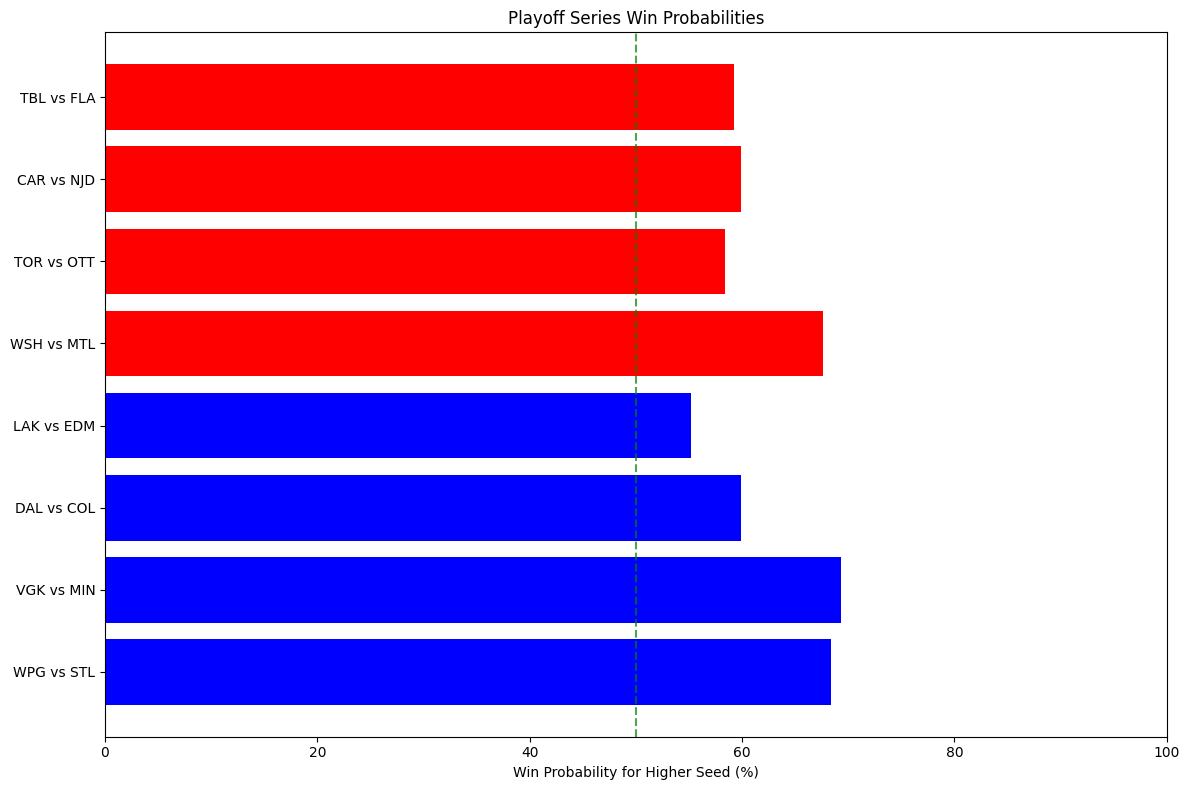

In [17]:
def predict_series(matchup_df, models, n_simulations=1000):
    """Predict series outcome using the pre-trained models with updated historical series length distribution"""
    # Extract team abbreviations for display
    top_seed = matchup_df['top_seed_abbrev'].iloc[0]
    bottom_seed = matchup_df['bottom_seed_abbrev'].iloc[0]
    
    # Initialize probabilities
    lr_prob = 0.5
    xgb_prob = 0.5
    ensemble_prob = 0.5
    
    # Check which models we have available and make predictions
    if 'lr' in models and 'model' in models['lr'] and 'features' in models['lr']:
        lr_model = models['lr']['model']
        lr_features = [f for f in models['lr']['features'] if f in matchup_df.columns]
        
        # Check if we have all the required features
        if len(lr_features) == len(models['lr']['features']):
            try:
                lr_prob = lr_model.predict_proba(matchup_df[lr_features])[:, 1][0]
                print(f"LR model prediction: {lr_prob*100:.1f}% chance for {top_seed} to win series")
            except Exception as e:
                print(f"Error making LR prediction: {str(e)}")
                lr_prob = 0.5
        else:
            missing_features = [f for f in models['lr']['features'] if f not in matchup_df.columns]
            print(f"Missing {len(missing_features)} features for LR model: {missing_features[:3]}...")
    
    if 'xgb' in models and 'model' in models['xgb'] and 'features' in models['xgb']:
        xgb_model = models['xgb']['model']
        xgb_features = [f for f in models['xgb']['features'] if f in matchup_df.columns]
        
        # Check if we have all the required features
        if len(xgb_features) == len(models['xgb']['features']):
            try:
                xgb_prob = xgb_model.predict_proba(matchup_df[xgb_features])[:, 1][0]
                print(f"XGB model prediction: {xgb_prob*100:.1f}% chance for {top_seed} to win series")
            except Exception as e:
                print(f"Error making XGB prediction: {str(e)}")
                xgb_prob = 0.5
        else:
            missing_features = [f for f in models['xgb']['features'] if f not in matchup_df.columns]
            print(f"Missing {len(missing_features)} features for XGB model: {missing_features[:3]}...")
    
    # Calculate ensemble probability if we have both models
    if 'lr' in models and 'xgb' in models:
        ensemble_prob = (lr_prob + xgb_prob) / 2
        print(f"Ensemble model prediction: {ensemble_prob*100:.1f}% chance for {top_seed} to win series")
    
    # Determine which probability to use based on mode
    if models['mode'] == 'ensemble' and lr_prob != 0.5 and xgb_prob != 0.5:
        base_prob = ensemble_prob
        model_used = 'Ensemble (LR + XGB)'
    elif models['mode'] == 'lr' and lr_prob != 0.5:
        base_prob = lr_prob
        model_used = 'Logistic Regression'
    elif models['mode'] == 'xgb' and xgb_prob != 0.5:
        base_prob = xgb_prob
        model_used = 'XGBoost'
    elif lr_prob != 0.5:
        base_prob = lr_prob
        model_used = 'Logistic Regression (fallback)'
    elif xgb_prob != 0.5:
        base_prob = xgb_prob
        model_used = 'XGBoost (fallback)'
    else:
        # Use points difference as fallback
        if 'points_diff' in matchup_df.columns:
            points_diff = matchup_df['points_diff'].iloc[0]
            base_prob = 1 / (1 + np.exp(-0.05 * points_diff))
            model_used = 'Points-based'
        else:
            # Default to slight higher seed advantage
            base_prob = 0.55
            model_used = 'Default'
    
    print(f"Final prediction using {model_used} model: {base_prob*100:.1f}%")
    
    # Run simulations using the base probability
    # Initialize counters
    higher_seed_wins = 0
    win_distribution = {
        '4-0': 0, '4-1': 0, '4-2': 0, '4-3': 0,  # Higher seed wins
        '0-4': 0, '1-4': 0, '2-4': 0, '3-4': 0   # Lower seed wins
    }
    
    # Updated historical distribution of NHL playoff series outcomes based on provided data
    # 4 games: 14.0%, 5 games: 24.3%, 6 games: 33.6%, 7 games: 28.1%
    # Normalize within each outcome (higher seed wins vs lower seed wins)
    total_percent = 14.0 + 24.3 + 33.6 + 28.1
    
    # Distribution for when higher seed wins (maintain relative proportions)
    higher_seed_outcome_dist = {
        '4-0': 14.0/total_percent, 
        '4-1': 24.3/total_percent, 
        '4-2': 33.6/total_percent, 
        '4-3': 28.1/total_percent
    }
    
    # Same distribution for when lower seed wins
    lower_seed_outcome_dist = {
        '0-4': 14.0/total_percent, 
        '1-4': 24.3/total_percent, 
        '2-4': 33.6/total_percent, 
        '3-4': 28.1/total_percent
    }
    
    # Run simulations - determine series winner based on probability
    for _ in range(n_simulations):
        # Determine if higher seed wins the series
        higher_seed_wins_series = np.random.random() < base_prob
        
        if higher_seed_wins_series:
            higher_seed_wins += 1
            # Select a series outcome based on historical distribution
            outcome = np.random.choice(['4-0', '4-1', '4-2', '4-3'], 
                                    p=[higher_seed_outcome_dist['4-0'], 
                                        higher_seed_outcome_dist['4-1'],
                                        higher_seed_outcome_dist['4-2'],
                                        higher_seed_outcome_dist['4-3']])
            win_distribution[outcome] += 1
        else:
            # Select a series outcome for lower seed winning
            outcome = np.random.choice(['0-4', '1-4', '2-4', '3-4'], 
                                    p=[lower_seed_outcome_dist['0-4'], 
                                        lower_seed_outcome_dist['1-4'],
                                        lower_seed_outcome_dist['2-4'],
                                        lower_seed_outcome_dist['3-4']])
            win_distribution[outcome] += 1
    
    # Calculate win percentage and confidence interval
    win_pct = higher_seed_wins / n_simulations
    z = 1.96  # 95% confidence interval
    ci_width = z * np.sqrt((win_pct * (1 - win_pct)) / n_simulations)
    ci_lower = max(0, win_pct - ci_width)
    ci_upper = min(1, win_pct + ci_width)
    
    # Format results
    results = {
        'top_seed': top_seed,
        'bottom_seed': bottom_seed,
        'win_probability': win_pct,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'win_distribution': win_distribution,
        'model_used': model_used,
        'lr_probability': lr_prob,
        'xgb_probability': xgb_prob,
        'ensemble_probability': ensemble_prob,
        'n_simulations': n_simulations
    }
    
    return results

# Generate predictions for each matchup if models are available
if playoff_matchups and models:
    print("Generating predictions for playoff matchups...\n")
    
    # Store all results
    all_predictions = {}
    
    # Process each conference and series
    for conference, matchups in playoff_matchups.items():
        all_predictions[conference] = {}
        
        for series_id, matchup in matchups.items():
            print(f"\n--- {conference} Conference - {series_id} ---")
            top_team = matchup['top_seed']['teamName']
            bottom_team = matchup['bottom_seed']['teamName']
            print(f"{top_team} vs {bottom_team}")
            
            # Create matchup data
            matchup_df = create_matchup_data(matchup['top_seed'], matchup['bottom_seed'], team_data)
            
            # Generate prediction
            if not matchup_df.empty:
                prediction = predict_series(matchup_df, models)
                all_predictions[conference][series_id] = prediction
                
                # Display prediction results
                win_prob = prediction['win_probability'] * 100
                ci_lower = prediction['ci_lower'] * 100
                ci_upper = prediction['ci_upper'] * 100
                
                print(f"\nPredicted winner: {top_team if win_prob > 50 else bottom_team} "
                      f"({win_prob:.1f}% chance, 95% CI: {ci_lower:.1f}% - {ci_upper:.1f}%)")
                
                # Display series outcome distribution
                dist = prediction['win_distribution']
                total = sum(dist.values())
                
                print("\nSeries outcome distribution:")
                # Display higher seed outcomes
                for outcome in ['4-0', '4-1', '4-2', '4-3']:
                    pct = (dist[outcome] / total) * 100
                    print(f"  {top_team} wins {outcome}: {pct:.1f}%")
                    
                # Display lower seed outcomes
                for outcome in ['0-4', '1-4', '2-4', '3-4']:
                    pct = (dist[outcome] / total) * 100
                    # Convert to lower seed perspective (e.g., 0-4 becomes 4-0 from lower seed view)
                    lower_outcome = f"{outcome[-1]}-{outcome[0]}"
                    print(f"  {bottom_team} wins {lower_outcome}: {pct:.1f}%")
            else:
                print("Could not create matchup data - missing team information")
    
    # Plot visualization of the predictions
    plt.figure(figsize=(12, 8))
    
    # Keep track of all series for plotting
    all_series_labels = []
    all_win_probs = []
    all_colors = []
    
    # Process each conference
    for conf_idx, (conference, conf_predictions) in enumerate(all_predictions.items()):
        # Set different colors for each conference
        conf_color = 'blue' if conf_idx == 0 else 'red'
        
        for series_id, prediction in conf_predictions.items():
            top_seed = prediction['top_seed']
            bottom_seed = prediction['bottom_seed']
            win_prob = prediction['win_probability'] * 100
            
            # Create label
            label = f"{top_seed} vs {bottom_seed}"
            all_series_labels.append(label)
            all_win_probs.append(win_prob)
            all_colors.append(conf_color)
    
    # Create horizontal bar chart of win probabilities
    y_pos = np.arange(len(all_series_labels))
    plt.barh(y_pos, all_win_probs, color=all_colors)
    plt.yticks(y_pos, all_series_labels)
    plt.xlabel('Win Probability for Higher Seed (%)')
    plt.title('Playoff Series Win Probabilities')
    plt.axvline(x=50, color='green', linestyle='--', alpha=0.7)
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()
else:
    print("Either playoff matchups or models are not available for predictions.")

## 18. Simulate Entire Playoff Bracket

Let's simulate the entire playoff bracket to predict which teams are most likely to advance to later rounds and win the Stanley Cup.

In [18]:
def simulate_playoff_bracket(playoff_matchups, team_data, models, n_simulations=1000, detailed_tracking=True):
    """Simulate the entire playoff bracket with comprehensive tracking and results.
    
    Args:
        playoff_matchups: Dictionary of first round matchups by conference
        team_data: DataFrame with team stats data
        models: Dictionary of trained models for predictions
        n_simulations: Number of simulations to run
        detailed_tracking: Whether to track detailed matchup stats (potential matchups, etc.)
        
    Returns:
        Dictionary containing comprehensive simulation results
    """
    # Track advancement for each team
    team_advancement = {}
    
    # Track all possible matchups for each round if detailed tracking enabled
    round_matchups = {
        'round_2': {},  # Division Finals
        'conf_final': {},  # Conference Finals
        'final': {}  # Stanley Cup Final
    }
    
    # Initialize all playoff teams
    for conference, matchups in playoff_matchups.items():
        for series_id, matchup in matchups.items():
            top_seed = matchup['top_seed']['teamAbbrev']
            bottom_seed = matchup['bottom_seed']['teamAbbrev']
            
            if top_seed not in team_advancement:
                team_advancement[top_seed] = {
                    'round_1': 0,
                    'round_2': 0,
                    'conf_final': 0,
                    'final': 0,
                    'champion': 0,
                    'teamName': matchup['top_seed']['teamName'],
                    'total_games': 0  # Track total playoff games played
                }
            
            if bottom_seed not in team_advancement:
                team_advancement[bottom_seed] = {
                    'round_1': 0,
                    'round_2': 0,
                    'conf_final': 0,
                    'final': 0,
                    'champion': 0,
                    'teamName': matchup['bottom_seed']['teamName'],
                    'total_games': 0  # Track total playoff games played
                }
    
    # Updated historical distribution of NHL playoff series outcomes
    # 4 games: 14.0%, 5 games: 24.3%, 6 games: 33.6%, 7 games: 28.1%
    series_length_dist = [0.140, 0.243, 0.336, 0.281]
    
    # Store the most common full bracket result if detailed tracking is enabled
    bracket_results_count = {}
    
    # Run simulations
    for sim in range(n_simulations):
        if sim % 100 == 0 and sim > 0:
            print(f"Completed {sim} simulations...")
            
        # Track winners for each round
        round_1_winners = {}
        round_2_winners = {}
        conf_winners = {}
        stanley_cup_winner = None
        
        # Track this simulation's bracket result if detailed tracking is enabled
        current_bracket = [] if detailed_tracking else None
        
        # First round
        for conference, matchups in playoff_matchups.items():
            round_1_winners[conference] = {}
            for series_id, matchup in matchups.items():
                # Create matchup data
                matchup_df = create_matchup_data(matchup['top_seed'], matchup['bottom_seed'], team_data)
                
                # Get prediction for the series
                if not matchup_df.empty:
                    # Get win probability from pre-trained model
                    win_prob = 0.5  # default
                    
                    # Use the model's prediction if available
                    if 'lr' in models and 'model' in models['lr'] and 'features' in models['lr']:
                        lr_features = [f for f in models['lr']['features'] if f in matchup_df.columns]
                        
                        if len(lr_features) == len(models['lr']['features']):
                            try:
                                lr_prob = models['lr']['model'].predict_proba(matchup_df[lr_features])[:, 1][0]
                                win_prob = lr_prob
                            except Exception:
                                pass
                    
                    # Use XGBoost if available
                    if 'xgb' in models and 'model' in models['xgb'] and 'features' in models['xgb']:
                        xgb_features = [f for f in models['xgb']['features'] if f in matchup_df.columns]
                        
                        if len(xgb_features) == len(models['xgb']['features']):
                            try:
                                xgb_prob = models['xgb']['model'].predict_proba(matchup_df[xgb_features])[:, 1][0]
                                # Use ensemble if both models are available
                                if win_prob != 0.5:
                                    win_prob = (win_prob + xgb_prob) / 2
                                else:
                                    win_prob = xgb_prob
                            except Exception:
                                pass
                    
                    # Fallback to points difference if models failed
                    if win_prob == 0.5 and 'points_diff' in matchup_df.columns:
                        points_diff = matchup_df['points_diff'].iloc[0]
                        win_prob = 1 / (1 + np.exp(-0.05 * points_diff))
                    
                    # Simulate the series outcome
                    higher_seed_wins = np.random.random() < win_prob
                    
                    if higher_seed_wins:
                        winner = matchup['top_seed']
                        loser = matchup['bottom_seed']
                    else:
                        winner = matchup['bottom_seed']
                        loser = matchup['top_seed']
                    
                    # Simulate series length based on historical distribution
                    series_length = np.random.choice([4, 5, 6, 7], p=series_length_dist)
                    
                    # Track games played for both teams
                    team_advancement[winner['teamAbbrev']]['total_games'] += series_length
                    team_advancement[loser['teamAbbrev']]['total_games'] += series_length
                    
                    # Store winner for next round
                    round_1_winners[conference][series_id] = {
                        'team': winner,
                        'original_matchup': series_id
                    }
                    
                    # Record advancement
                    team_advancement[winner['teamAbbrev']]['round_1'] += 1
                    
                    # Add to current bracket if detailed tracking is enabled
                    if detailed_tracking:
                        current_bracket.append(f"{winner['teamAbbrev']} over {loser['teamAbbrev']}")
        
        # Process Second round (Division Finals)
        for conference, r1_winners in round_1_winners.items():
            round_2_winners[conference] = {}
            
            # Extract division information from series_ids
            divisions = set()
            for key in r1_winners.keys():
                if len(key) >= 1 and key[0].isalpha():
                    divisions.add(key[0])
            
            # Create second round matchups
            for division in divisions:
                # Find matchup winners from this division's first round
                div_winners = [r1_winners[k] for k in r1_winners if k.startswith(division)]
                
                if len(div_winners) >= 2:  # Need at least two teams for a matchup
                    # Identify teams
                    team1 = div_winners[0]['team']
                    team2 = div_winners[1]['team']
                    
                    # Determine seeding (copied from playoff_model_streamlit.py logic)
                    div_rank1 = team1.get('division_rank', 99)
                    div_rank2 = team2.get('division_rank', 99)
                    
                    if 'wildcard_rank' in team1:
                        div_rank1 = 3 + team1['wildcard_rank']
                    
                    if 'wildcard_rank' in team2:
                        div_rank2 = 3 + team2['wildcard_rank']
                    
                    # Determine seeds based on ranks
                    if div_rank1 <= div_rank2:  # Lower number is better rank
                        top_seed = team1
                        bottom_seed = team2
                    else:
                        top_seed = team2
                        bottom_seed = team1
                    
                    # Track this potential matchup if detailed tracking is enabled
                    if detailed_tracking:
                        matchup_key = f"{top_seed['teamAbbrev']}_vs_{bottom_seed['teamAbbrev']}"
                        if matchup_key not in round_matchups['round_2']:
                            round_matchups['round_2'][matchup_key] = {
                                'conference': conference,
                                'division': division,
                                'top_seed': top_seed['teamAbbrev'],
                                'bottom_seed': bottom_seed['teamAbbrev'],
                                'top_seed_name': top_seed['teamName'],
                                'bottom_seed_name': bottom_seed['teamName'],
                                'count': 0,
                                'top_seed_wins': 0
                            }
                        round_matchups['round_2'][matchup_key]['count'] += 1
                    
                    # Create matchup data
                    matchup_df = create_matchup_data(top_seed, bottom_seed, team_data)
                    
                    # Get win probability using same logic as first round
                    win_prob = 0.5
                    try:
                        if 'lr' in models and 'model' in models['lr'] and 'features' in models['lr']:
                            lr_features = [f for f in models['lr']['features'] if f in matchup_df.columns]
                            if len(lr_features) == len(models['lr']['features']):
                                lr_prob = models['lr']['model'].predict_proba(matchup_df[lr_features])[:, 1][0]
                                win_prob = lr_prob
                                
                        if 'xgb' in models and 'model' in models['xgb'] and 'features' in models['xgb']:
                            xgb_features = [f for f in models['xgb']['features'] if f in matchup_df.columns]
                            if len(xgb_features) == len(models['xgb']['features']):
                                xgb_prob = models['xgb']['model'].predict_proba(matchup_df[xgb_features])[:, 1][0]
                                if win_prob != 0.5:
                                    win_prob = (win_prob + xgb_prob) / 2
                                else:
                                    win_prob = xgb_prob
                                    
                        if win_prob == 0.5 and 'points_diff' in matchup_df.columns:
                            points_diff = matchup_df['points_diff'].iloc[0]
                            win_prob = 1 / (1 + np.exp(-0.05 * points_diff))
                    except Exception:
                        win_prob = 0.5
                    
                    # Simulate the outcome
                    higher_seed_wins = np.random.random() < win_prob
                    winner = top_seed if higher_seed_wins else bottom_seed
                    loser = bottom_seed if higher_seed_wins else top_seed
                    
                    # Record the win if detailed tracking is enabled
                    if detailed_tracking and higher_seed_wins:
                        matchup_key = f"{top_seed['teamAbbrev']}_vs_{bottom_seed['teamAbbrev']}"
                        round_matchups['round_2'][matchup_key]['top_seed_wins'] += 1
                    
                    # Simulate series length based on historical distribution
                    series_length = np.random.choice([4, 5, 6, 7], p=series_length_dist)
                    
                    # Track games played for both teams
                    team_advancement[winner['teamAbbrev']]['total_games'] += series_length
                    team_advancement[loser['teamAbbrev']]['total_games'] += series_length
                    
                    # Store winner for next round
                    round_2_winners[conference][f"{division}_final"] = {
                        'team': winner,
                        'division': division
                    }
                    
                    # Record advancement
                    team_advancement[winner['teamAbbrev']]['round_2'] += 1
                    
                    # Add to current bracket if detailed tracking is enabled
                    if detailed_tracking:
                        current_bracket.append(f"{winner['teamAbbrev']} over {loser['teamAbbrev']}")
        
        # Conference Finals
        for conference, r2_winners in round_2_winners.items():
            if len(r2_winners) >= 2:  # Make sure we have both divisional final results
                # Get the two division winners
                div_winners = list(r2_winners.values())
                
                if len(div_winners) == 2:
                    team1 = div_winners[0]['team']
                    team2 = div_winners[1]['team']
                    
                    # Determine seeding (similar to above)
                    div_rank1 = team1.get('division_rank', 99)
                    div_rank2 = team2.get('division_rank', 99)
                    
                    if 'wildcard_rank' in team1:
                        div_rank1 = 3 + team1['wildcard_rank']
                    
                    if 'wildcard_rank' in team2:
                        div_rank2 = 3 + team2['wildcard_rank']
                    
                    # Use points as tiebreaker if ranks are equal
                    if div_rank1 == div_rank2:
                        team1_data = team_data[team_data['teamAbbrev'] == team1['teamAbbrev']]
                        team2_data = team_data[team_data['teamAbbrev'] == team2['teamAbbrev']]
                        
                        points1 = team1_data['points'].iloc[0] if not team1_data.empty and 'points' in team1_data.columns else 0
                        points2 = team2_data['points'].iloc[0] if not team2_data.empty and 'points' in team2_data.columns else 0
                        
                        if points1 > points2:
                            top_seed = team1
                            bottom_seed = team2
                        else:
                            top_seed = team2
                            bottom_seed = team1
                    else:
                        top_seed = team1 if div_rank1 < div_rank2 else team2
                        bottom_seed = team2 if div_rank1 < div_rank2 else team1
                    
                    # Track this potential matchup if detailed tracking is enabled
                    if detailed_tracking:
                        matchup_key = f"{top_seed['teamAbbrev']}_vs_{bottom_seed['teamAbbrev']}"
                        if matchup_key not in round_matchups['conf_final']:
                            round_matchups['conf_final'][matchup_key] = {
                                'conference': conference,
                                'top_seed': top_seed['teamAbbrev'],
                                'bottom_seed': bottom_seed['teamAbbrev'],
                                'top_seed_name': top_seed['teamName'],
                                'bottom_seed_name': bottom_seed['teamName'],
                                'count': 0,
                                'top_seed_wins': 0
                            }
                        round_matchups['conf_final'][matchup_key]['count'] += 1
                    
                    # Create matchup data
                    matchup_df = create_matchup_data(top_seed, bottom_seed, team_data)
                    
                    # Get win probability
                    win_prob = 0.5
                    try:
                        if 'lr' in models and 'model' in models['lr'] and 'features' in models['lr']:
                            lr_features = [f for f in models['lr']['features'] if f in matchup_df.columns]
                            if len(lr_features) == len(models['lr']['features']):
                                lr_prob = models['lr']['model'].predict_proba(matchup_df[lr_features])[:, 1][0]
                                win_prob = lr_prob
                                
                        if 'xgb' in models and 'model' in models['xgb'] and 'features' in models['xgb']:
                            xgb_features = [f for f in models['xgb']['features'] if f in matchup_df.columns]
                            if len(xgb_features) == len(models['xgb']['features']):
                                xgb_prob = models['xgb']['model'].predict_proba(matchup_df[xgb_features])[:, 1][0]
                                if win_prob != 0.5:
                                    win_prob = (win_prob + xgb_prob) / 2
                                else:
                                    win_prob = xgb_prob
                    except Exception:
                        # Use points difference as fallback
                        if 'points_diff' in matchup_df.columns:
                            points_diff = matchup_df['points_diff'].iloc[0]
                            win_prob = 1 / (1 + np.exp(-0.05 * points_diff))
                    
                    # Determine winner
                    higher_seed_wins = np.random.random() < win_prob
                    winner = top_seed if higher_seed_wins else bottom_seed
                    loser = bottom_seed if higher_seed_wins else top_seed
                    
                    # Record the win if detailed tracking is enabled
                    if detailed_tracking and higher_seed_wins:
                        matchup_key = f"{top_seed['teamAbbrev']}_vs_{bottom_seed['teamAbbrev']}"
                        round_matchups['conf_final'][matchup_key]['top_seed_wins'] += 1
                    
                    # Simulate series length based on historical distribution
                    series_length = np.random.choice([4, 5, 6, 7], p=series_length_dist)
                    
                    # Track games played for both teams
                    team_advancement[winner['teamAbbrev']]['total_games'] += series_length
                    team_advancement[loser['teamAbbrev']]['total_games'] += series_length
                    
                    # Store winner for final
                    conf_winners[conference] = {
                        'team': winner,
                        'conference': conference
                    }
                    
                    # Record advancement
                    team_advancement[winner['teamAbbrev']]['conf_final'] += 1
                    
                    # Add to current bracket if detailed tracking is enabled
                    if detailed_tracking:
                        current_bracket.append(f"{winner['teamAbbrev']} over {loser['teamAbbrev']}")
        
        # Stanley Cup Final
        if len(conf_winners) == 2:
            # Get the two conference champions
            conf_champs = list(conf_winners.values())
            
            if len(conf_champs) == 2:
                team1 = conf_champs[0]['team']
                team2 = conf_champs[1]['team']
                
                # Determine home ice advantage based on regular season points
                team1_data = team_data[team_data['teamAbbrev'] == team1['teamAbbrev']]
                team2_data = team_data[team_data['teamAbbrev'] == team2['teamAbbrev']]
                
                points1 = team1_data['points'].iloc[0] if not team1_data.empty and 'points' in team1_data.columns else 0
                points2 = team2_data['points'].iloc[0] if not team2_data.empty and 'points' in team2_data.columns else 0
                
                if points1 >= points2:
                    top_seed = team1
                    bottom_seed = team2
                else:
                    top_seed = team2
                    bottom_seed = team1
                
                # Track this potential matchup if detailed tracking is enabled
                if detailed_tracking:
                    matchup_key = f"{top_seed['teamAbbrev']}_vs_{bottom_seed['teamAbbrev']}"
                    if matchup_key not in round_matchups['final']:
                        round_matchups['final'][matchup_key] = {
                            'top_seed': top_seed['teamAbbrev'],
                            'bottom_seed': bottom_seed['teamAbbrev'],
                            'top_seed_name': top_seed['teamName'],
                            'bottom_seed_name': bottom_seed['teamName'],
                            'count': 0,
                            'top_seed_wins': 0
                        }
                    round_matchups['final'][matchup_key]['count'] += 1
                
                # Create matchup data
                matchup_df = create_matchup_data(top_seed, bottom_seed, team_data)
                
                # Get win probability
                win_prob = 0.5
                try:
                    if 'lr' in models and 'model' in models['lr'] and 'features' in models['lr']:
                        lr_features = [f for f in models['lr']['features'] if f in matchup_df.columns]
                        if len(lr_features) == len(models['lr']['features']):
                            lr_prob = models['lr']['model'].predict_proba(matchup_df[lr_features])[:, 1][0]
                            win_prob = lr_prob
                            
                    if 'xgb' in models and 'model' in models['xgb'] and 'features' in models['xgb']:
                        xgb_features = [f for f in models['xgb']['features'] if f in matchup_df.columns]
                        if len(xgb_features) == len(models['xgb']['features']):
                            xgb_prob = models['xgb']['model'].predict_proba(matchup_df[xgb_features])[:, 1][0]
                            if win_prob != 0.5:
                                win_prob = (win_prob + xgb_prob) / 2
                            else:
                                win_prob = xgb_prob
                except Exception:
                    # Use points difference as fallback
                    if 'points_diff' in matchup_df.columns:
                        points_diff = matchup_df['points_diff'].iloc[0]
                        win_prob = 1 / (1 + np.exp(-0.05 * points_diff))
                
                # Determine winner
                higher_seed_wins = np.random.random() < win_prob
                winner = top_seed if higher_seed_wins else bottom_seed
                loser = bottom_seed if higher_seed_wins else top_seed
                
                # Record the win if detailed tracking is enabled
                if detailed_tracking and higher_seed_wins:
                    matchup_key = f"{top_seed['teamAbbrev']}_vs_{bottom_seed['teamAbbrev']}"
                    round_matchups['final'][matchup_key]['top_seed_wins'] += 1
                
                # Simulate series length based on historical distribution
                series_length = np.random.choice([4, 5, 6, 7], p=series_length_dist)
                
                # Track games played for both teams
                team_advancement[winner['teamAbbrev']]['total_games'] += series_length
                team_advancement[loser['teamAbbrev']]['total_games'] += series_length
                
                # Record champion and finalist
                team_advancement[winner['teamAbbrev']]['champion'] += 1
                team_advancement[winner['teamAbbrev']]['final'] += 1
                team_advancement[loser['teamAbbrev']]['final'] += 1
                
                # Add to current bracket if detailed tracking is enabled
                if detailed_tracking:
                    current_bracket.append(f"{winner['teamAbbrev']} over {loser['teamAbbrev']}")
                    stanley_cup_winner = winner['teamAbbrev']
        
        # Store this bracket result if detailed tracking is enabled
        if detailed_tracking and current_bracket:
            bracket_key = "|".join(current_bracket)
            if bracket_key not in bracket_results_count:
                bracket_results_count[bracket_key] = 0
            bracket_results_count[bracket_key] += 1
    
    # Calculate advancement percentages and average games played
    results_df = pd.DataFrame()
    for team, rounds in team_advancement.items():
        team_row = {'teamAbbrev': team, 'teamName': rounds.get('teamName', team)}
        for round_name in ['round_1', 'round_2', 'conf_final', 'final', 'champion']:
            team_row[round_name] = rounds[round_name] / n_simulations
        
        # Calculate average games played when team makes the playoffs
        team_row['avg_games_played'] = rounds['total_games'] / n_simulations
        
        results_df = pd.concat([results_df, pd.DataFrame([team_row])], ignore_index=True)
    
    # Sort by championship probability
    results_df = results_df.sort_values('champion', ascending=False)
    
    # Prepare return values based on detailed tracking option
    results = {
        'team_advancement': results_df
    }
    
    # Add detailed tracking results if enabled
    if detailed_tracking:
        # Find the most common bracket result
        most_common_bracket = max(bracket_results_count.items(), key=lambda x: x[1]) if bracket_results_count else ("", 0)
        
        # Convert matchup counts to DataFrames
        round2_df = pd.DataFrame([
            {
                'conference': data['conference'],
                'division': data.get('division', 'N/A'),
                'matchup': f"{data['top_seed_name']} vs {data['bottom_seed_name']}",
                'count': data['count'],
                'probability': data['count']/n_simulations*100,
                'top_seed_win_pct': data['top_seed_wins']/data['count']*100 if data['count'] > 0 else 0
            }
            for data in round_matchups['round_2'].values()
        ]).sort_values('count', ascending=False) if round_matchups['round_2'] else pd.DataFrame()
        
        conf_final_df = pd.DataFrame([
            {
                'conference': data['conference'],
                'matchup': f"{data['top_seed_name']} vs {data['bottom_seed_name']}",
                'count': data['count'],
                'probability': data['count']/n_simulations*100,
                'top_seed_win_pct': data['top_seed_wins']/data['count']*100 if data['count'] > 0 else 0
            }
            for data in round_matchups['conf_final'].values()
        ]).sort_values('count', ascending=False) if round_matchups['conf_final'] else pd.DataFrame()
        
        final_df = pd.DataFrame([
            {
                'matchup': f"{data['top_seed_name']} vs {data['bottom_seed_name']}",
                'count': data['count'],
                'probability': data['count']/n_simulations*100,
                'top_seed_win_pct': data['top_seed_wins']/data['count']*100 if data['count'] > 0 else 0
            }
            for data in round_matchups['final'].values()
        ]).sort_values('count', ascending=False) if round_matchups['final'] else pd.DataFrame()
        
        results.update({
            'most_common_bracket': {
                'bracket': most_common_bracket[0].split('|') if most_common_bracket[0] else [],
                'count': most_common_bracket[1],
                'probability': most_common_bracket[1]/n_simulations*100
            },
            'round2_matchups': round2_df,
            'conf_final_matchups': conf_final_df,
            'final_matchups': final_df
        })
    
    return results

## Run Playoff Bracket Simulation

Let's run the combined playoff bracket simulation with configurable options.

Running full playoff bracket simulation with updated series length distribution...
Series length distribution: 4 games: 14.0%, 5 games: 24.3%, 6 games: 33.6%, 7 games: 28.1%

Running 10000 simulations of the entire playoff bracket...


Completed 100 simulations...
Completed 200 simulations...
Completed 200 simulations...
Completed 300 simulations...
Completed 300 simulations...
Completed 400 simulations...
Completed 400 simulations...
Completed 500 simulations...
Completed 500 simulations...
Completed 600 simulations...
Completed 600 simulations...
Completed 700 simulations...
Completed 700 simulations...
Completed 800 simulations...
Completed 800 simulations...
Completed 900 simulations...
Completed 900 simulations...
Completed 1000 simulations...
Completed 1000 simulations...
Completed 1100 simulations...
Completed 1100 simulations...
Completed 1200 simulations...
Completed 1200 simulations...
Completed 1300 simulations...
Completed 1300 simulations...
Completed 1400 simulations...
Completed 1400 simulations...
Completed 1500 simulations...
Completed 1500 simulations...
Completed 1600 simulations...
Completed 1600 simulations...
Completed 1700 simulations...
Completed 1700 simulations...
Completed 1800 simulations.

,teamName,round_1,round_2,conf_final,final,champion,avg_games_played
0,Winnipeg Jets,66.4%,35.7%,21.2%,21.2%,13.2%,12.9
14,Tampa Bay Lightning,58.0%,34.4%,19.5%,19.5%,10.4%,12.2
8,Washington Capitals,66.1%,36.3%,19.6%,19.6%,9.9%,12.8
2,Vegas Golden Knights,69.3%,34.3%,16.6%,16.6%,8.9%,12.7
4,Dallas Stars,58.8%,28.9%,16.1%,16.1%,8.7%,11.7


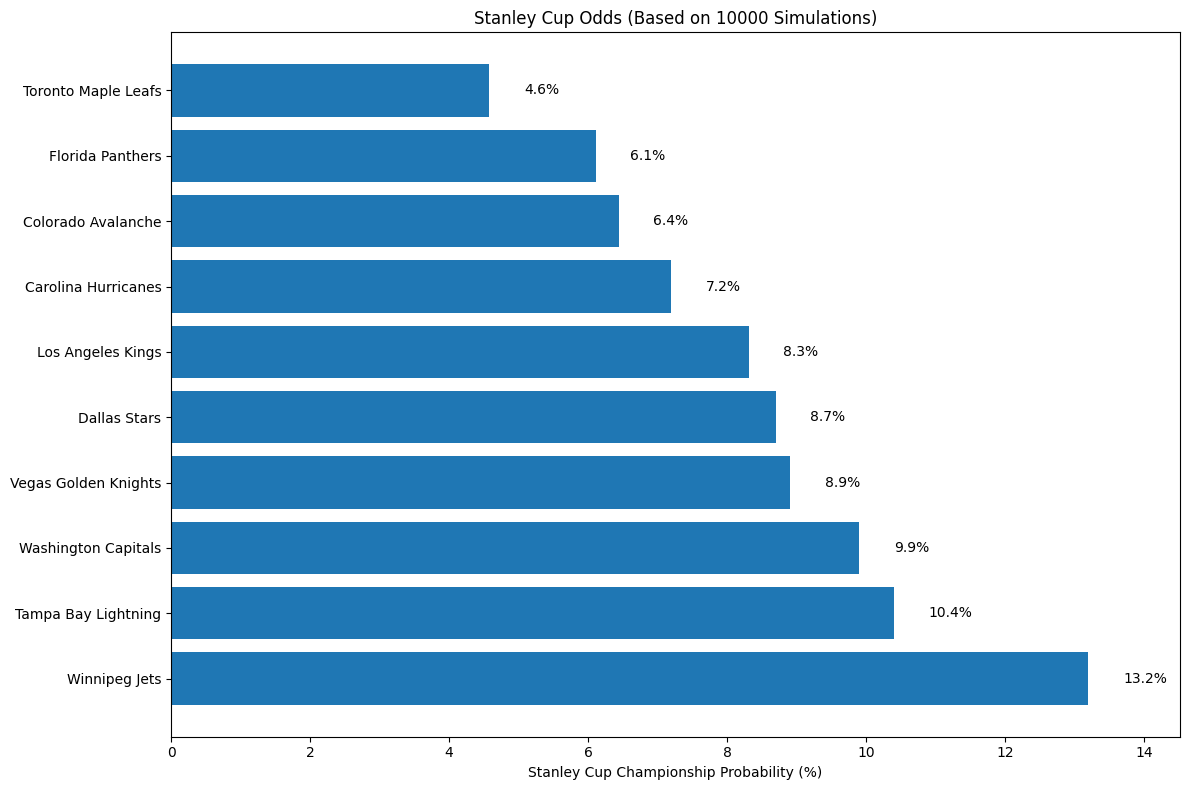

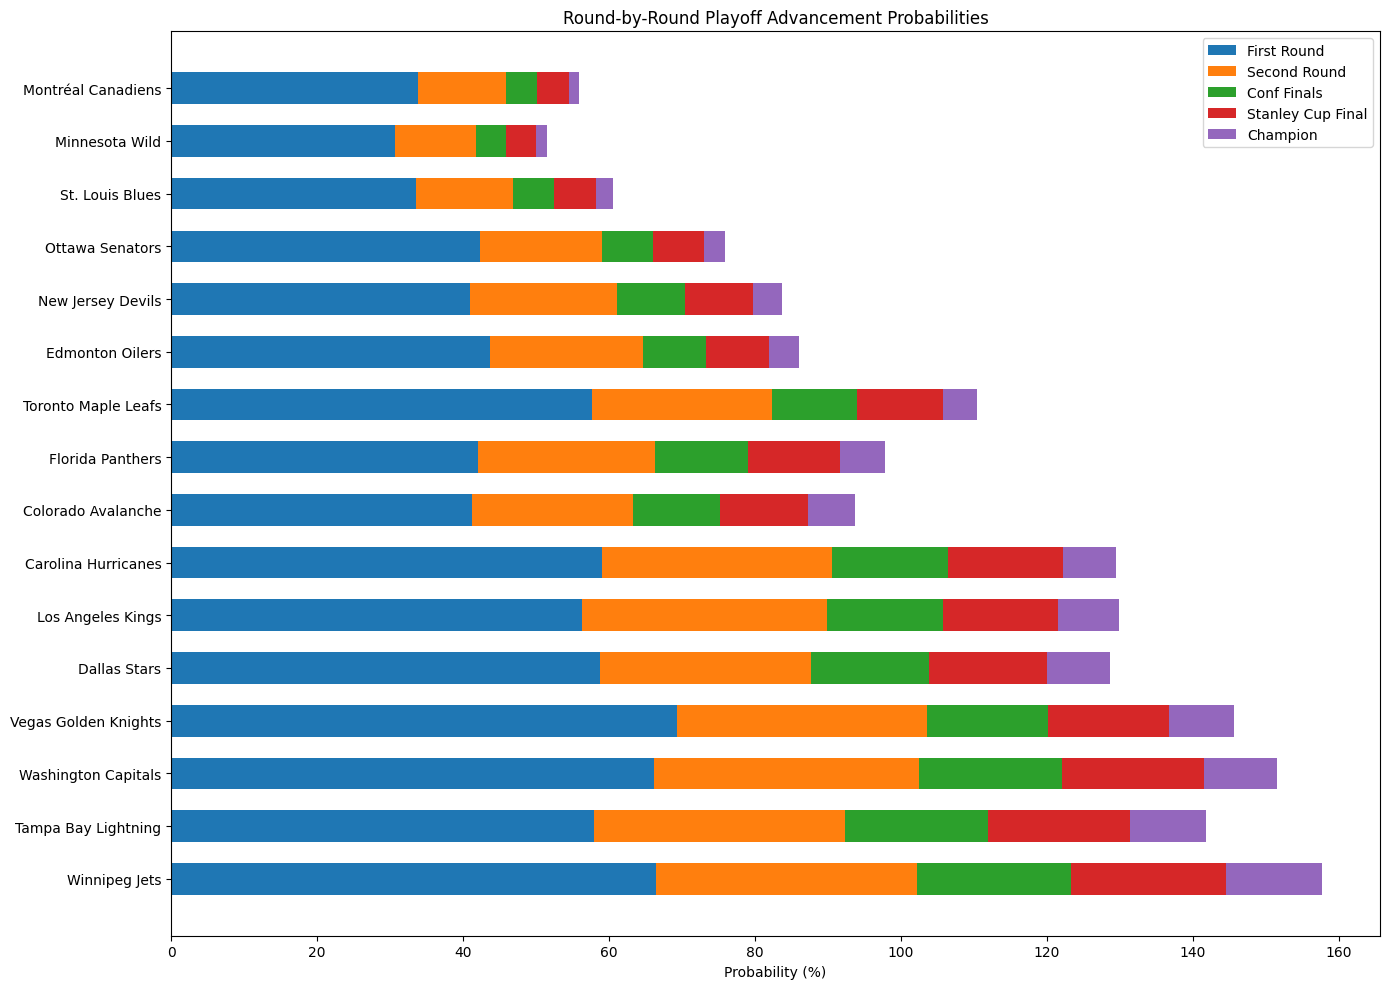


=== POTENTIAL SECOND ROUND MATCHUPS ===


,conference,division,matchup,count,probability,top_seed_win_pct
3,Eastern,M,Washington Capitals vs Carolina Hurricanes,3900,39.0%,52.7%
5,Western,C,Winnipeg Jets vs Dallas Stars,3899,39.0%,55.1%
4,Western,P,Vegas Golden Knights vs Los Angeles Kings,3882,38.8%,43.6%
2,Eastern,A,Toronto Maple Leafs vs Tampa Bay Lightning,3362,33.6%,44.6%
0,Western,P,Vegas Golden Knights vs Edmonton Oilers,3047,30.5%,57.0%
7,Western,C,Winnipeg Jets vs Colorado Avalanche,2746,27.5%,51.8%
9,Eastern,M,Washington Capitals vs New Jersey Devils,2715,27.2%,58.0%
8,Eastern,A,Tampa Bay Lightning vs Ottawa Senators,2433,24.3%,64.9%
15,Eastern,A,Toronto Maple Leafs vs Florida Panthers,2404,24.0%,40.1%
12,Eastern,M,Carolina Hurricanes vs Montréal Canadiens,1998,20.0%,65.6%



=== POTENTIAL CONFERENCE FINALS MATCHUPS ===


,conference,matchup,count,probability,top_seed_win_pct
5,Eastern,Washington Capitals vs Tampa Bay Lightning,1273,12.7%,47.4%
20,Western,Winnipeg Jets vs Vegas Golden Knights,1236,12.4%,58.8%
2,Western,Winnipeg Jets vs Los Angeles Kings,1226,12.3%,56.5%
1,Eastern,Tampa Bay Lightning vs Carolina Hurricanes,1070,10.7%,55.2%
0,Western,Vegas Golden Knights vs Dallas Stars,1000,10.0%,46.5%
23,Western,Dallas Stars vs Los Angeles Kings,959,9.6%,51.7%
22,Eastern,Washington Capitals vs Florida Panthers,879,8.8%,53.1%
8,Eastern,Washington Capitals vs Toronto Maple Leafs,860,8.6%,59.2%
25,Eastern,Toronto Maple Leafs vs Carolina Hurricanes,796,8.0%,45.7%
7,Eastern,Carolina Hurricanes vs Florida Panthers,766,7.7%,43.3%



=== POTENTIAL STANLEY CUP FINALS MATCHUPS ===


,matchup,count,probability,top_seed_win_pct
11,Winnipeg Jets vs Washington Capitals,416,4.2%,60.6%
20,Winnipeg Jets vs Tampa Bay Lightning,408,4.1%,56.6%
7,Dallas Stars vs Tampa Bay Lightning,334,3.3%,43.7%
26,Winnipeg Jets vs Carolina Hurricanes,329,3.3%,62.0%
31,Washington Capitals vs Vegas Golden Knights,308,3.1%,56.8%
...,...,...,...,...
46,Minnesota Wild vs New Jersey Devils,35,0.4%,51.4%
16,Edmonton Oilers vs Montréal Canadiens,31,0.3%,74.2%
62,St. Louis Blues vs Montréal Canadiens,29,0.3%,69.0%
61,Minnesota Wild vs Ottawa Senators,27,0.3%,51.9%



=== MOST LIKELY PLAYOFF BRACKET ===
Probability: 0.1% (8 of 10000 simulations)
Series results:
  First Round: WPG over STL
  First Round: VGK over MIN
  First Round: DAL over COL
  First Round: LAK over EDM
  First Round: WSH over MTL
  First Round: TOR over OTT
  First Round: NJD over CAR
  First Round: TBL over FLA
  Second Round: LAK over VGK
  Second Round: DAL over WPG
  Second Round: TBL over TOR
  Second Round: WSH over NJD
  Conference Finals: DAL over LAK
  Conference Finals: TBL over WSH
  Stanley Cup Final: TBL over DAL
Data saved to /workspaces/NHL_playoff_model/data/playoff_sim_results_20242025.csv
Data saved to /workspaces/NHL_playoff_model/data/playoff_round2_matchups_20242025.csv
Data saved to /workspaces/NHL_playoff_model/data/playoff_conf_finals_matchups_20242025.csv
Data saved to /workspaces/NHL_playoff_model/data/playoff_stanley_cup_matchups_20242025.csv


In [20]:
# Run a full playoff bracket simulation
print("Running full playoff bracket simulation with updated series length distribution...")
print("Series length distribution: 4 games: 14.0%, 5 games: 24.3%, 6 games: 33.6%, 7 games: 28.1%")

n_sims = 10000  # Number of simulations to run
if playoff_matchups and 'team_data' in locals() and not team_data.empty and models:
    # Run the simulation
    print(f"\nRunning {n_sims} simulations of the entire playoff bracket...")
    bracket_results = simulate_playoff_bracket(playoff_matchups, team_data, models, n_simulations=n_sims)
    
    # Display results
    if 'team_advancement' in bracket_results:
        results_df = bracket_results['team_advancement']
        print(f"\nAdvancement probabilities from {n_sims} simulations:")
        display_cols = ['teamName', 'round_1', 'round_2', 'conf_final', 'final', 'champion', 'avg_games_played']
        
        # Format percentages for better readability
        results_display = results_df[display_cols].copy()
        for col in ['round_1', 'round_2', 'conf_final', 'final', 'champion']:
            results_display[col] = (results_display[col] * 100).round(1).astype(str) + '%'
        results_display['avg_games_played'] = results_display['avg_games_played'].round(1)
        
        # Display the top teams
        print("\nTop Stanley Cup contenders:")
        display(results_display.head(5))
        
        # Create a bar chart of Stanley Cup odds
        plt.figure(figsize=(12, 8))
        top_teams = results_df.sort_values('champion', ascending=False).head(10)
        
        bars = plt.barh(top_teams['teamName'], top_teams['champion'] * 100)
        plt.xlabel('Stanley Cup Championship Probability (%)')
        plt.title(f'Stanley Cup Odds (Based on {n_sims} Simulations)')
        plt.xlim(0, top_teams['champion'].max() * 100 * 1.1)  # Add 10% padding
        
        # Add percentage labels to the end of each bar
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.5
            plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
                    va='center', fontsize=10)
            
        plt.tight_layout()
        plt.show()
        
        # Show the round-by-round advancement probabilities
        plt.figure(figsize=(14, 10))
        
        # Select playoff teams and rounds to plot
        teams_to_plot = results_df.iloc[:16]  # Top 16 teams (all playoff teams)
        rounds_to_plot = ['round_1', 'round_2', 'conf_final', 'final', 'champion']
        round_labels = ['First Round', 'Second Round', 'Conf Finals', 'Stanley Cup Final', 'Champion']
        
        # Create the stacked bar chart
        bottom = np.zeros(len(teams_to_plot))
        width = 0.6
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        for i, (col, label) in enumerate(zip(rounds_to_plot, round_labels)):
            plt.barh(teams_to_plot['teamName'], teams_to_plot[col] * 100, 
                    left=bottom, height=width, label=label, color=colors[i])
            bottom += teams_to_plot[col] * 100
            
        plt.xlabel('Probability (%)')
        plt.title('Round-by-Round Playoff Advancement Probabilities')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        # If detailed tracking was enabled, show additional visualizations
        if 'round2_matchups' in bracket_results:
            # Display potential second round matchups
            print("\n=== POTENTIAL SECOND ROUND MATCHUPS ===")
            round2_display = bracket_results['round2_matchups'].copy()
            round2_display['probability'] = round2_display['probability'].round(1).astype(str) + '%'
            round2_display['top_seed_win_pct'] = round2_display['top_seed_win_pct'].round(1).astype(str) + '%'
            display(round2_display)
            
            # Display potential conference finals matchups
            print("\n=== POTENTIAL CONFERENCE FINALS MATCHUPS ===")
            conf_display = bracket_results['conf_final_matchups'].copy()
            conf_display['probability'] = conf_display['probability'].round(1).astype(str) + '%'
            conf_display['top_seed_win_pct'] = conf_display['top_seed_win_pct'].round(1).astype(str) + '%'
            display(conf_display)
            
            # Display potential Stanley Cup Finals matchups
            print("\n=== POTENTIAL STANLEY CUP FINALS MATCHUPS ===")
            finals_display = bracket_results['final_matchups'].copy()
            finals_display['probability'] = finals_display['probability'].round(1).astype(str) + '%'
            finals_display['top_seed_win_pct'] = finals_display['top_seed_win_pct'].round(1).astype(str) + '%'
            display(finals_display)
            
            # Display most common bracket
            most_common = bracket_results['most_common_bracket']
            print("\n=== MOST LIKELY PLAYOFF BRACKET ===")
            print(f"Probability: {most_common['probability']:.1f}% ({most_common['count']} of {n_sims} simulations)")
            print("Series results:")
            for i, result in enumerate(most_common['bracket']):
                round_name = "First Round" if i < 8 else "Second Round" if i < 12 else "Conference Finals" if i < 14 else "Stanley Cup Final"
                print(f"  {round_name}: {result}")
        
        # Save the results
        save_data(results_df, f"playoff_sim_results_{season_str}.csv")
        
        # Save detailed results if available
        if 'round2_matchups' in bracket_results:
            save_data(bracket_results['round2_matchups'], f"playoff_round2_matchups_{season_str}.csv")
            save_data(bracket_results['conf_final_matchups'], f"playoff_conf_finals_matchups_{season_str}.csv")
            save_data(bracket_results['final_matchups'], f"playoff_stanley_cup_matchups_{season_str}.csv")
else:
    print("Missing required data (playoff_matchups, team_data, or models) to run the simulation")